# Multiple-stressor simulations

With this notebook we are able to run in silico multiple-stressor experiments on communities of species. We do this to study the sources and patterns of non-additivity between stressors. We define some useful functions which allow us to control many aspects of the simulated communities and of the multiple-stressor experiments themselves. 

We start with a very simple, but general model. If community dynamics can introduce non-additvity here, then they certaintly can in more complex models (e.g. with non-linear functional responses). 

$ N_i = Ki + \sum A_{ij} N_j $

$ N = (1-A)^{-1} K  $

We descirbe two ways that a stressor can effect a community. Stressors can effect the carrying capacity of species (Type I effects) and also their interactions with other species (Type II effects). 

Type I effect:
$ N = (1-A)^{-1} K+\delta K  $

Type II effect: 
$ N = (1-A+\epsilon)^{-1} K  $


### Contents  <a class="anchor" id="1"></a>
* [Setup and functions](#2)
* [Extinction/Invasions](#3)
* [Observation effects](#4)
* [Stressor overlap](#5)
* [Predicted vs actual synergism](#6)
* [Sources of non-additivity - Figure](#7) 
* [Observation Effects - Figure](#8) 

### Packages and Functions <a class="anchor" id="2"></a>
[Top](#1)

In [4]:
# General use
import numpy as np
from numpy.linalg import eig, norm, inv                                
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint                                      # Solves a system of ODEs
from scipy import stats                                                 # For pearson's correlation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap   # For colour gradients

In [5]:
# Function to create a Lotka Voltera Vector Field that takes:

#    N        = Vector of biomasses 
#    t        = Time 
#    Aij      = Interaction matrix 
#    rho      = Carrying capacities 

##############################################################

def field(N,t,Aij,rho):                           
    thresh = 1e-10                              # Threshold biomass below which a species is extinct
    limit = 500                                 # Limit to biomass - indicates divergence model (not interesting)
    D=np.diag(N/abs(rho))                       # Creating a diagonal matrix with abundances divided by rho 
    vect_N = np.dot(D,rho-N+np.dot(Aij,N))      # Lotka-Voltera equation
    
    ### Extinction threshhold, species can't have negative biomass (set extinct species to 0.. setting to thresh can cause some weird glitches when investigating invasions)
    extinct=np.where(N<thresh)[0]                    
    vect_N[extinct]=np.maximum(vect_N[extinct], 0) 
                            
    ### Divergence threshold - Not relevant because we're using the while loops? ###
    #divergent=np.where(N>limit)[0]                     # Divergence threhold - stops species have very large values 
    #vect_N[divergent]=np.zeros(len(divergent))         # Setting biomass of divergent species to 0 
    
    return vect_N                                      # Return a vector made up of the changes in N over time

In [6]:
# Function to generate a pool of species (not all will co-exist) that takes:

#    S        = Number of Speices 
#    mu       = Mean interaction strength
#    sigma    = Spread of interaction strengths 
#    zeta     = Scales carrying capacity (larger values give more uneven biomass distributions)
#    cen      = Controls the center of the biomass distribution (0 means 50% of species in pool will assemble)

##############################################################

def random_assembly(S, mu, sigma, zeta, cen):            
    thresh = 1e-10                                # Threshold biomass below which a species is extinct
    limit = 500                                   # Limit to biomass - indicates divergence phase of model (not interesting to us)
    tmax = 30*np.sqrt(S)                          # Maximum time (function of S)
    t= np.linspace(0, tmax,int(100*tmax))         # Timeframe (resolution function of tmax) 
    
    divergence = True                                                  
    while divergence == True:                                          
        
        # Drawing rho (carrying capacity) centered on cen and scaled by zeta 
        rho = np.random.normal(0, 1, size = S)*zeta + cen              
        
        # Drawing Aij (interaction matrix) interaction strengths scaled by number of species. Diagonals set to 0. 
        Aij = mu/S+sigma/np.sqrt(S)*np.random.normal(0, 1, size = (S, S))    
        Aij = Aij - np.diag(np.diag(Aij))                              
        
        # Intial biomasses (all positive)
        N0=0.01*np.random.uniform(0, 1, size = S)                      
        
        # Dynamics - odeint solves the differential equations that are created using the field function (Lotka Voltera)
        Nt=odeint(field, N0, t, args=(Aij, rho))                      
        Nf=Nt[-1,:]                                                   
        
        # Divergence control (repeat loop if some species biomass is too large)
        if max(Nf) < limit:                                           
            divergence = False
        else:
            print("Divergence")
    
    # Identify persisting and extinct species (based on biomass and rate of biomass change)
    rates=field(Nf, tmax, Aij, rho)/Nf                                       # Rates of change of biomass
    persist = np.where((Nf > thresh)&(rates>np.log(thresh)/(20*tmax)))[0]    # List of persisting species - to persist a species must have biomass above threshold AND not be trending towards extinction
    s = len(persist)                                                         # Number of persisting species
    Aij_p = Aij[persist, :][:, persist]                                      # Interaction matrix of persisting species
    extinct = np.where(Nf < thresh)[0]                                       # List of extinct species 
    
    # draw biomass of extinct species so that they are above 0 (to avoid gliches in odeint)
    Nf[extinct] = np.random.uniform(thresh/2,thresh, size=len(extinct))*np.ones(len(extinct))              
    
    # Use environmental sensitivity matrix to make species that were heading towards equilibrium to go straight to equilibrium. Nf is definitely equilibrium now.
    Nf[persist] = np.dot(inv(np.eye(s) - Aij_p), rho[persist])                
    
    return rho, Aij, Nf, persist

In [36]:
##### Aggregate Properties 


#########         Shannon diversity index        ###############
# Entropy of the system 
# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)

def entropy(biomass):
    positives = np.where(biomass > 0)
    p = biomass[positives]/sum(biomass[positives])
    return np.exp(-sum(p*np.log(p)))


#########             Hills number              #################

# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)
# q refers to the "order" of Hill number. Hill numbers of order q or effective number of species
# Chosing q = 1 or 0 gives me issues. But any other number is working fine

def hill(biomass):
    q = 2
    positives = np.where(biomass > 0)
    p = biomass[positives]/sum(biomass[positives])
    return np.power(norm(p, q), q/(1.-q))


#########        Simpson diversity index       #################
# The probability that two entities taken at random are the same type
# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)

def simp(biomass):
    positives = np.where(biomass > 0)
    p = biomass[positives]/sum(biomass[positives])
    return sum(p*(1-p))


In [37]:
##### Aggregate Properties 


# Shannon diversity index   
def entropy(biomass):
    p = biomass/sum(biomass)
    return np.exp(-sum(p*np.log(p)))


# Hill numbers         
def hill(biomass):
    q = 2
    p = biomass/sum(biomass)
    return np.power(norm(p, q), q/(1.-q))


# Simpson diversity index   
def simp(biomass):
    p = biomass/sum(biomass)
    return sum(p*p)



In [38]:
# Function to run multiple-stressor in silico experiments that takes: 

#    num_com      = The number of communities to generate 
#    num_stress   = The number of multiple stressor experiments to run per community
#    S            = Number of species in the species pool (for each community)
#    zeta         = Controls biomass distribution (for each community)
#    cen          = Controls the center of the biomass distribution (0 means 50% of species in pool will assemble)
#    mu           = Mean interaction strength (for each community)
#    sigma        = Spread of interaction strengths (for each community)
#    system       = If "closed", the system is closed to invasions, otherwise invasions can occur 
#    Type_I       = If "neg"/"pos"/"no", then type I effects are always negative/positive/excluded. Otherwise, they are mixed 
#    sI_d         = The direction/bias of stressors. Set as 0 if Type_I is pos or neg. 
#    sI_i         = The intensity of the type I effects (for both stressors)
#    Type_I_rel   = If "true", stressors are relative to rho, otherwise stressors are independent of rho
#    Type_II      = If "true" type II effects are included, otherwise they are set to 0 
#    sII_i        = The intensity of the type II effects (for both stressors)

##############################################################

def stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system,
                        Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i):
    
    ############ Initial Checks ################# 
    
    print("S: ", S)
    print("zeta: ", zeta)
    print("cen: ", cen)
    print("mu: ", mu)
    print("sigma: ", sigma)
    if system == "closed":    
        print("Invasions: No")
    else: 
        print("Invasions: Yes")
    print("")    
    if Type_I == "neg": 
        print("Type I effects: Negative")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    elif Type_I == "pos": 
        print("Type I effects: Positive")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    elif Type_I == "no": 
        print("Type I effects: None")
    else: 
        print("Type I effects: Mixed")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    
    if Type_II == "true":
        print("Type II effects: Yes")
        print("Type_II Intensity: np.random.uniform( 0,",sII_i,")")  
    else:
        print("Type II effects: No")
    print("")    
    print("Number of communities to generate: ", num_com)
    print("Number of stressor experiments per community: ", num_stress)
    print("")
    

    ###################### Loop to generate communities #############################
    
    # Defining vectors to be filled 
    mean_Non_add_rel=np.zeros(num_com)                          
    mean_Non_add_abs=np.zeros(num_com)
    mean_Synergism_rel=np.zeros(num_com)                         
    mean_Synergism_abs=np.zeros(num_com)  
    mean_Synergism_rich_abs = np.zeros(num_com)
    mean_Synergism_diversity_abs = np.zeros(num_com)
    mean_Synergism_total_abs = np.zeros(num_com)
    mean_Synergism_rich_rel = np.zeros(num_com)
    mean_Synergism_diversity_rel = np.zeros(num_com)
    mean_Synergism_total_rel = np.zeros(num_com)
    mean_Synergism_hill_abs = np.zeros(num_com)
    mean_Synergism_simp_abs = np.zeros(num_com)    
    mean_Synergism_Euc2_abs = np.zeros(num_com)
    mean_Ext_1 = np.zeros(num_com)
    mean_Ext_2 = np.zeros(num_com)
    mean_Ext_12 = np.zeros(num_com)
    mean_Inv_1 = np.zeros(num_com)
    mean_Inv_2 = np.zeros(num_com)
    mean_Inv_12 = np.zeros(num_com)
    mean_Dot_bound = np.zeros(num_com)   
    mean_Dot_bound_N = np.zeros(num_com)
    Stab = np.zeros(num_com)    
    Stab_Relative = np.zeros(num_com)
    Resilience = np.zeros(num_com)
    Collectivity = np.zeros(num_com) 
    mean_predicted_Non_add_rel = np.zeros(num_com)   
    mean_predicted_Synergism_rel = np.zeros(num_com)        
    mean_predicted_Non_add_abs = np.zeros(num_com)                    
    mean_predicted_Synergism_abs = np.zeros(num_com)  
    
    ### Actual loop to generate "num_com" communities
    for k in range(num_com):
        # run random assembly
        rho, Aij, Nf, persist = random_assembly(S, mu, sigma, zeta, cen)
        
        #### option to close to invasion
        # need to rename S to s so that I don't keep changing the input to random_assembly
        if system == "closed":
            rho = rho[persist]
            Aij = Aij[persist, :][:, persist]
            Nf = Nf[persist]
            s = len(persist)        
        else:
            s = S
        

        ################## Loop to run stressor simulations on each community ###################
        # Another check
        if num_com == 1: 
            print("Persisting species: ", len(persist),"/",S)
            print("")

        # Defining vectors to be filled 
        Non_add_rel=np.zeros(num_stress)                          
        Non_add_abs=np.zeros(num_stress)
        Synergism_rel=np.zeros(num_stress)                         
        Synergism_abs=np.zeros(num_stress)  
        Synergism_rich_abs = np.zeros(num_stress)
        Synergism_diversity_abs = np.zeros(num_stress)
        Synergism_total_abs = np.zeros(num_stress)
        Synergism_rich_rel = np.zeros(num_stress)
        Synergism_diversity_rel = np.zeros(num_stress)
        Synergism_total_rel = np.zeros(num_stress)
        Synergism_hill_abs = np.zeros(num_stress)
        Synergism_simp_abs = np.zeros(num_stress)
        Synergism_Euc2_abs = np.zeros(num_stress)
        Ext_1 = np.zeros(num_stress)
        Ext_2 = np.zeros(num_stress)
        Ext_12 = np.zeros(num_stress)
        Inv_1 = np.zeros(num_stress)
        Inv_2 = np.zeros(num_stress)
        Inv_12 = np.zeros(num_stress)
        Dot_bound = np.zeros(num_stress)   
        Dot_bound_N = np.zeros(num_stress)        
        predicted_Non_add_rel = np.zeros(num_stress)   
        predicted_Synergism_rel = np.zeros(num_stress)        
        predicted_Non_add_abs = np.zeros(num_stress)                    
        predicted_Synergism_abs = np.zeros(num_stress)   
        intensity = np.zeros(num_stress)

        # Settings for dynamical models 
        t = np.linspace(0, 500, 100)              # Time (start, finish, resolution)
        thresh = 1e-10                            # Threshold biomass below which a species is extinct (if this is large there can be some artificial synergism)
        limit = 500                               # Limit to biomass - biomass above this indicates the model has entered a divergent phase (not biologically interesting)
        
        
        ### Actual loop to run "num_stress" stressor expeirments on each community
        for n in range(num_stress):               
            divergence=True                       # Divergence Control (while loop)
            while divergence==True:

                ########## Generate Stressors ##########

                ## Type I effects (for each stressor) - changes to carrying capacity ##
                # Stressor 1
                s1_I = np.random.normal(sI_d, 1, size=s)                  # s1's effect on each species (Type I) - vector with mean (direction) of sI_d and spread of 1 - uniform sampling of sphere
                s1_int = np.random.uniform(0, sI_i)                       # Store s1 intensity (sI_i is user defined - larger values give greater range of intensities)
                if Type_I == "neg":                                       # IF user decides to only use negative stressors
                    s1_I = abs(s1_I)                                      # Use abs to only consider negative stressors ...
                    s1_I = s1_int*s1_I#/norm(s1_I)                         # ... and then multiply stressor by intensity and normalize  
                elif Type_I == "pos":                                     # OR IF user decides to only use positive stressors
                    s1_I = np.negative(abs(s1_I))                         # Use abs to only consider negative stressors ... and flip signs with np.negative so that all stressors are positive
                    s1_I = s1_int*s1_I#/norm(s1_I)                         # ... and then multiply stressor by intensity and normalize 
                elif Type_I == "no":                                      # OR IF user decides to use no type I effects ... 
                    s2_I = np.zeros(s)                                    # ... set stressor to 0 
                else:                                                     # OTHERWISE
                    s1_I = s1_int*s1_I#/norm(s1_I)                         # just multiply stressor by intensity and normalized (mixed stressors)
 
                # Stressor 2
                s2_I = np.random.normal(sI_d, 1, size=s)                     
                s2_int = np.random.uniform(0, sI_i)
                if Type_I == "neg":                                       
                    s2_I = abs(s2_I)                                     
                    s2_I = s2_int*s2_I#/norm(s2_I) 
                elif Type_I == "pos":                                       
                    s2_I = np.negative(abs(s2_I))                                     
                    s2_I = s2_int*s2_I#/norm(s2_I) 
                elif Type_I == "no":
                    s2_I = np.zeros(s)
                else:                                                     
                    s2_I = s2_int*s2_I#/norm(s2_I)     
     
       
                ## Option to make type I stressor relative to carrying capacity 
                # need to use abs of rho, otherwise the stressors can flip sign if a species' rho is negative
                if Type_I_rel == "true":
                    s1_I = s1_I*abs(rho) 
                    s2_I = s2_I*abs(rho) 

    
                    
                ## Type II effects (for each stressor) - changes to interaction matrix ##
                # Stressor 1
                if Type_II == "true":                                         # IF user decides to include Type II stressor effects ...
                    s1_II = np.random.normal(0, 1, size = (s, s))             # ... randomly generates stressor 1's type II effect) ...
                    s1_II = s1_II-np.diag(np.diag(s1_II))                     # ... remove diagonals ...
                    s1_II = np.random.uniform(0, sII_i)*s1_II/norm(s1_II, 2)  # ... and multiply by intensity and normalize 
                else:                                                         # OTHERWISE
                    s1_II = np.random.uniform(0, 0, size = (s, s))            # set stressor to 0 

                # Stressor 2
                if Type_II == "true":
                    s2_II = np.random.normal(0, 1, size = (s, s))             
                    s2_II = s2_II-np.diag(np.diag(s2_II))                     
                    s2_II = np.random.uniform(0, sII_i)*s2_II/norm(s2_II, 2) 
                else:
                    s2_II = np.random.uniform(0, 0, size = (s, s))          

                    
                #########################################################################################     
                #           Prediction using Environmental Sensitity Matrix - no dynamics               #
                #########################################################################################
                
                #### Calculate environmental sensitivity matrix (for each community) ####
                B = np.eye(s)-Aij                           # Identity matrix minus Aij             
                V = inv(B)                                  # Inverse of the above

                # Calculate net effects of stressors based on environmental sensitivity matrix - Apply the stressors (need minus sign for set up) to the enviornmental sensitity matrix
                net_effect_s1 = np.dot(V, -s1_I)            
                net_effect_s2 = np.dot(V, -s2_I)
                net_effect_s12 = np.dot(V, -(s1_I+s2_I))

                # Calculate change in biomass - use np.maximum for element-wise max, set negative values to 0. 
                dn_1 = np.maximum((Nf + net_effect_s1), 0) - Nf       
                dn_2 = np.maximum((Nf + net_effect_s2), 0) - Nf
                dn_12 = np.maximum((Nf + net_effect_s12), 0) - Nf

                  
                #########################################################################################     
                #          Lotka-Voltera Dynamics - for stressors individually and combined             #
                #########################################################################################
                
                ### Nf is the equalibrium biomass before stressors
                ### Nt1[-1,:] is the equalibrium biomass after stressors 
                ### We are scaling up predictions from the species to the community (i.e. Compositional Null Model)
                
                Nt1=odeint(field, Nf, t, args=(Aij+s1_II, rho-s1_I))                       # DYNAMICS - stressor 1 (made up of type I and type II effects)
                ## Effect of stressor 1 on:
                DN_1=Nt1[-1,:] - Nf                                                        # Position in State Space
                Rich_1= len(np.where(Nt1[-1,:]>thresh)[0]) - len(np.where(Nf>thresh)[0])   # Richness
                Diversity_1 = entropy(Nt1[-1,:]) - entropy(Nf)                             # Shannon
                Total_1 = sum(Nt1[-1,:]) - sum(Nf)                                         # Total Biomass
                Hill_1 = hill(Nt1[-1,:]) - hill(Nf)                                        # Hill
                Simp_1 = simp(Nt1[-1,:]) - simp(Nf)                                        # Simpson

                
                Nt2=odeint(field, Nf, t, args=(Aij+s2_II, rho-s2_I))                       # DYNAMICS - stressor 2 (made up of type I and type II effects)
                ## Effect of stressor 2 on:
                DN_2=Nt2[-1,:] - Nf                                                        # Position in State Space
                Rich_2= len(np.where(Nt2[-1,:]>thresh)[0]) - len(np.where(Nf>thresh)[0])   # Richness
                Diversity_2 = entropy(Nt2[-1,:]) - entropy(Nf)                             # Shannon
                Total_2 = sum(Nt2[-1,:]) - sum(Nf)                                         # Total Biomass
                Hill_2 = hill(Nt2[-1,:]) - hill(Nf)                                        # Hill
                Simp_2 = simp(Nt2[-1,:]) - simp(Nf)                                        # Simpson


                Nt12=odeint(field, Nf, t, args=(Aij+s1_II+s2_II, rho-s1_I-s2_I))           # DYNAMICS - stressors 1+2 (made up of type I and type II effects)
                ## Effect of stressor 2 on:
                DN_12=Nt12[-1,:] - Nf                                                      # Position in State Space
                Rich_12= len(np.where(Nt12[-1,:]>thresh)[0]) - len(np.where(Nf>thresh)[0]) # Richness
                Diversity_12 = entropy(Nt12[-1,:]) - entropy(Nf)                           # Shannon
                Total_12 = sum(Nt12[-1,:]) - sum(Nf)                                       # Total Biomass
                Hill_12 = hill(Nt12[-1,:]) - hill(Nf)                                      # Hill
                Simp_12 = simp(Nt12[-1,:]) - simp(Nf)                                      # Simpson




                ######## Controling Divergence #########
                diverged1=np.where(Nt1[-1,:]>limit)[0]
                div1=len(diverged1)
                diverged2=np.where(Nt2[-1,:]>limit)[0]
                div2=len(diverged2)
                diverged12=np.where(Nt12[-1,:]>limit)[0]
                div12=len(diverged12)
                if np.max([div1, div2, div12])==0:
                    divergence=False
                else:
                    print("divergence")


            ##### Vectors filled after each experiment #####              

            ###########################################################
            #    Predictions from environmental sensitivity matrix    #
            ###########################################################
            
            #### Eucledian distance ####
            # default order of norm is 2 - Euclidean norm 
            predicted_Non_add_rel[n] = norm((dn_1 + dn_2) - dn_12) / norm(dn_1 + dn_2)   
            predicted_Synergism_rel[n] = norm(dn_12) / norm(dn_1 + dn_2) - 1           
            predicted_Non_add_abs[n] = norm((dn_1 + dn_2)-dn_12)                       
            predicted_Synergism_abs[n] = norm(dn_12) - norm((dn_1 + dn_2))   
            
            ###########################################################
            #          Actual results from dynamical models           #
            ###########################################################            
            
            ##########   Agregate Properties   ##########
            
            ## Eucledian Distance ##
            # default order of norm is 2 - Euclidean norm 
            Non_add_rel[n] = norm((DN_1 + DN_2) - DN_12) / norm(DN_1 + DN_2)   # Non-additivity relative to additive (Euclidean) 
            Synergism_rel[n] = norm(DN_12) / norm(DN_1 + DN_2) - 1             # Synergism relative to additive (Euclidean) 
            Non_add_abs[n] = norm((DN_1 + DN_2)-DN_12)                         # Absolute Non-additivity (Euclidean) 
            Synergism_abs[n] = norm(DN_12) - norm((DN_1 + DN_2))               # Absolute Synergism (Euclidean) 
      
            ## Eucledian in relative biomass space
            # divid all DNs by Nf
            Synergism_Euc2_abs[n] = norm(DN_12/Nf) - norm((DN_1/Nf + DN_2/Nf))      
            
            ## Richness - Absolute Synergism ##
            Synergism_rich_abs[n] = abs(Rich_12) - abs((Rich_1 + Rich_2))   

            ## Diversity - Absolute Synergism ## 
            Synergism_diversity_abs[n] = abs(Diversity_12) - abs((Diversity_1 + Diversity_2)) 

            ## Total Biomass - Absolute Synergism ## 
            Synergism_total_abs[n] = abs(Total_12) - abs((Total_1 + Total_2))                 

            ## Hill - Absolute Synergism ## 
            Synergism_hill_abs[n] = abs(Hill_12) - abs((Hill_1 + Hill_2))                 

            ## Simp - Absolute Synergism ## 
            Synergism_simp_abs[n] = abs(Simp_12) - abs((Simp_1 + Simp_2))                 



                 
            ##########   Extinctions and Invasions   ##########
            
            # species that were in the pool but not in the assembled community     
            E1 = np.where(Nf<=thresh)[0]   
                        
            # species that were not in the assembled community after the stressor simulation
            E2_1 = np.where(Nt1[-1,:]<thresh)[0]      # stressor 1
            E2_2 = np.where(Nt2[-1,:]<thresh)[0]      # stressor 2
            E2_12 = np.where(Nt12[-1,:]<thresh)[0]    # stressors 1 + 2

            # extinctions - in the assembled community before, but not after, the stressor simulation (in E2 but not in E1)
            Ext_1[n] = len(np.where(np.in1d(E2_1, E1, invert = True) == True)[0])
            Ext_2[n] = len(np.where(np.in1d(E2_2, E1, invert = True) == True)[0])
            Ext_12[n] = len(np.where(np.in1d(E2_12, E1, invert = True) == True)[0])

            # invasions - in the assembled community after, but not before, the stressor simulation (in E1 but not in E2)
            Inv_1[n] = len(np.where(np.in1d(E1, E2_1, invert = True) == True)[0])
            Inv_2[n] = len(np.where(np.in1d(E1, E2_2, invert = True) == True)[0])
            Inv_12[n] = len(np.where(np.in1d(E1, E2_12, invert = True) == True)[0])
        
        
            ##########   Measure of Stressors   ##########

            # Dot Product of Bounded Effects
            dK_s1 = np.minimum(s1_I/rho, np.ones(s))                        # Bounded Stressor Effect (Decrease in carrying capacity of sI)
            dK_s2 = np.minimum(s2_I/rho, np.ones(s))                        # Bounded Stressor Effect (Decrease in carrying capacity of sI)
            #prefactor[n] = (-np.sign(min(min(-s1_I), min(-s2_I))) + 1)/2   # 0 if both stressors are positive, else 1 (tries to account for positive stressors)
            Dot_bound[n] = np.dot(dK_s1, dK_s2)                             # Bounded Dot product of dK and dK

            # Transformed Dot Product of Bounded Effects (to account for species interactions using environmental sensitivity matrix)
            V = inv(np.eye(s) - Aij)                                    # Enviornmental sensitivity matrix
            dN_s1 = np.minimum(np.dot(V, dK_s1)/Nf, np.ones(s))         # Apply dK to the environmental sensitivity matrix to get dN
            dN_s2 = np.minimum(np.dot(V, dK_s2)/Nf, np.ones(s))         # Apply dK to the environmental sensitivity matrix to get dN  
            Dot_bound_N[n] = np.dot(dN_s1, dN_s2)                       # Bounded Dot product of dN and dN

            # Measure of stressor intensity 
            intensity[n] = s1_int + s2_int


        ### Keep track of loops (depending on num_com)
            if num_com == 1:
                if n%100==0:
                    print(n)
        if num_com > 1:
            if k%50==0:
                print(k)        

                
        ##### Vectors filled after each experiment - now with the mean values for each community #####                      
        
        mean_predicted_Non_add_rel[k] = np.mean(predicted_Non_add_rel)
        mean_predicted_Synergism_rel[k] = np.mean(predicted_Synergism_rel)          
        mean_predicted_Non_add_abs[k] = np.mean(predicted_Non_add_abs)                
        mean_predicted_Synergism_abs[k] = np.mean(predicted_Synergism_abs) 

        mean_Non_add_rel[k]= np.mean(Non_add_rel)                  
        mean_Non_add_abs[k]= np.mean(Non_add_abs)
        mean_Synergism_rel[k]= np.mean(Synergism_rel)                      
        mean_Synergism_abs[k]= np.mean(Synergism_abs)

        mean_Synergism_rich_abs[k]= np.mean(Synergism_rich_abs)
        mean_Synergism_diversity_abs[k]= np.mean(Synergism_diversity_abs)
        mean_Synergism_total_abs[k]= np.mean(Synergism_total_abs)
        mean_Synergism_Euc2_abs[k] = np.mean(Synergism_Euc2_abs)
        mean_Synergism_hill_abs[k]= np.mean(Synergism_hill_abs)
        mean_Synergism_simp_abs[k]= np.mean(Synergism_simp_abs)
        
        mean_Ext_1[k]= np.mean(Ext_1)
        mean_Ext_2[k]= np.mean(Ext_2)
        mean_Ext_12[k]= np.mean(Ext_12)

        mean_Inv_1[k]= np.mean(Inv_1)
        mean_Inv_2[k]= np.mean(Inv_2)
        mean_Inv_12[k]= np.mean(Inv_12)
        
        mean_Dot_bound[k]= np.mean(Dot_bound)
        mean_Dot_bound_N[k]= np.mean(Dot_bound_N)

        #### Community characteristics
        B = np.eye(s)-Aij                                 
        V = inv(B)                                        # Environmental sensitivity matrix
        D = np.diag(Nf)
        J = np.dot(-D,B)                                  # Jacobian matrix

        Stab[k] = 1/norm(V, 2)                            # Inverse of the norm of the environmental sensitivity matrix 
        Stab_Relative[k] = 1/norm(inv(np.dot(B, D)))      # Similar to Inverse of the norm of the jacobian matrix 
        Resilience[k] = -max(np.real(eig(J)[0]))          # Asymptotic Resilience - computed from dominant eigenvalue of community matrix
        #Collectivity[k] = max(abs(eig(Aij)[0]))        

    print("")
    
    # Return options, depending on if one community or many communities were used 
    if num_com > 1:
        return mean_Synergism_Euc2_abs, intensity, mean_predicted_Non_add_rel, mean_predicted_Synergism_rel, mean_predicted_Non_add_abs, mean_predicted_Synergism_abs, Stab, Stab_Relative, Resilience, mean_Non_add_abs, mean_Non_add_rel, mean_Synergism_rel, mean_Synergism_abs, mean_Synergism_rich_abs, mean_Synergism_diversity_abs, mean_Synergism_total_abs, mean_Synergism_hill_abs, mean_Synergism_simp_abs, mean_Synergism_rich_rel, mean_Synergism_diversity_rel, mean_Synergism_total_rel, mean_Ext_1, mean_Ext_2, mean_Ext_12, mean_Inv_1, mean_Inv_2, mean_Inv_12, mean_Dot_bound
    else:
        return Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound

        

In [39]:
##### Functions for figures #######

# colours
j_blue = (68/255, 114/255, 255/255)
j_yell = (255/255, 196/255, 0/255)
j_yell2 = (255/255, 150/255, 0/255)

# colour gradients
yellow_grad = ["white", j_yell]
yellow_cmap = LinearSegmentedColormap.from_list("mycmap", yellow_grad)
blue_grad = ["white", j_blue]
blue_cmap = LinearSegmentedColormap.from_list("mycmap", blue_grad)
red_grad = ["white", "red"]
red_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad)

##############################################################

# Function to make the observation effect plots

#    X            = Vector of absolute synergism measured in one community metric (usually Euclidean Distance)
#    X            = Vector of absolute synergism measured in one community metric (e.g. Richess, Diversity)
#    percentile   = Include values up to this point (setting to e.g. 95 will improve clarity of plots)
#    r            = Number of rows in figure
#    c            = Number of columns in figure
#    n            = Subplot number


##############################################################


def observation_effect_plot(X, Y, percentile, r, c, n):    
    
    # subplot and setting axes (required for consistent text placement)
    ax = plt.subplot(r, c, n) 
    
    # filtering out the outliers for clarity
    dataframe = pd.DataFrame({'X':X, 'Y':Y})
    dataframe = dataframe[dataframe.X < np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.X > -np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.Y < np.percentile(abs(dataframe.Y),percentile)]
    dataframe = dataframe[dataframe.Y > -np.percentile(abs(dataframe.Y),percentile)]
    X = dataframe.X.values
    Y = dataframe.Y.values

    # setting limits of the plot
    nb = sum(~np.isnan(Y))
    Max_X = max(abs(X)) + max(abs(X))*0.1
    Max_Y = max(abs(Y)) + max(abs(Y))*0.1
    plt.xlim(-Max_X, Max_X)
    plt.ylim(-Max_Y, Max_Y)

    # drawing background gradients in each quadrant 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.5,
              extent = (0, Max_X, 0, Max_Y))   
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.25,
              extent = (0, Max_X, 0, Max_Y))      
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.5,
               extent = (0, -Max_X, 0, -Max_Y))   
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.25,
               extent = (0, -Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.1,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, -Max_X, 0, Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.025,
               extent = (0, -Max_X, 0, Max_Y))  

    # plotting different coloured points
    A_A = np.where((X<0) & (Y<0))[0]
    S_S = np.where((X>0) & (Y>0))[0]
    A_S = np.where((X>0) & (Y<0))[0]
    S_A = np.where((X<0) & (Y>0))[0]
    ADD = np.where((X==0) & (Y==0))[0]
    AD_N = np.where((X==0) & (Y!=0))[0]
    N_AD = np.where((X!=0) & (Y==0))[0]
    plt.scatter(X[A_A], Y[A_A], color = j_blue, alpha = 0.25, zorder=150, s=10)
    plt.scatter(X[S_S], Y[S_S], color = j_yell, alpha = 0.5, zorder=150, s=10)
    plt.scatter(X[ADD], Y[ADD], color = (0.4, 0.4, 0.4), alpha = 0.25, zorder=150, s=10)
    plt.scatter(X[S_A], Y[S_A], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[A_S], Y[A_S], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[AD_N], Y[AD_N], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[N_AD], Y[N_AD], color = 'r', alpha = 0.15, zorder=100, s=10)

    # plotting the percentages of points falling in each quadrant
    plt.text(.98, .98, str(round(len(np.where((Y > 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
             ha='right', va='top', transform=ax.transAxes, zorder=1000)
    plt.text(0.02, 0.02, str(round(len(np.where((Y < 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
             ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
    plt.text(.98, 0.02, str(round((len(np.where((Y < 0) & (X > 0))[0])+
                                  len(np.where((Y == 0) & (X > 0))[0])+
                                  len(np.where((Y < 0) & (X == 0))[0]))/nb * 100, 1))+"%", fontsize=10,
             color = 'r', ha='right', va='bottom', transform=ax.transAxes, zorder=1000)  
    plt.text(0.02, .98, str(round((len(np.where((Y > 0) & (X < 0))[0])+
                                  len(np.where((Y == 0) & (X < 0))[0])+
                                  len(np.where((Y > 0) & (X == 0))[0]))/nb * 100, 1))+"%", fontsize=10,
             color = 'r', ha='left', va='top', transform=ax.transAxes, zorder=1000)

    
    
    
##############################################################

# Function to make the boundary effect plots

#    Synergism_rel = Vector of relative synergism measured in Euclidean Distance
#    Non_add_rel   = Vector of relative non-additivity measured in Euclidean Distance
#    r             = Number of rows in figure
#    c             = Number of columns in figure
#    n             = Subplot number


##############################################################

def boundary_effect_plot(Synergism_rel, Non_add_rel, r, c, n):
    plt.subplot(r, c, n) 
    ants = np.where(Synergism_rel<0)[0]
    syns = np.where(Synergism_rel>0)[0]
    plt.scatter(Synergism_rel[ants], Non_add_rel[ants], color=j_blue, alpha=0.2, s=25)
    plt.scatter(Synergism_rel[syns], Non_add_rel[syns],  color=j_yell, alpha=0.5, s=25)
    X = np.linspace(0, 2, 100)
    plt.plot(X, X, color = (0, 0, 0), alpha =0.25, lw=4) 
    plt.plot(-X, X, color = (0, 0, 0), alpha =0.25, lw=4) 
    plt.ylim(0, .6)
    plt.xlim(-.6, .6)
    plt.xticks([-0.6, -0.3, 0, 0.3, 0.6], fontsize=16, labels=("-0.6", "-0.3", "0.0", "0.3", "0.6"))
    plt.yticks([0.3, 0.6], fontsize=16, labels=("0.3", "0.6"))
    plt.axvline(linewidth=1, color = (0, 0, 0), alpha =0.25, lw=4, linestyle='--');
    a = np.array([[0,0], [-0.75,0.], [-0.75,0.75]])
    b = np.array([[0,0], [0.75,0], [0.75,0.75]])
    t1 = plt.Polygon(a, color='black', alpha=0.07)
    t2 = plt.Polygon(b, color='black', alpha=0.07)
    plt.gca().add_patch(t1)
    plt.gca().add_patch(t2)



### Some technicalities:

- **Extinction Threshold**: When this is too high, a small amount of synergism can be artifically introduced (but this can appear large when considering relative synergism). Decreasing this down to 1e-10 removed this effect. If set too low e.g. 1e-20 then there are probelms with odeint. Odeint won't interact with species at 0 biomass (maybe it sees 1e-20 as 0) so these species don't get included in the dynamics. 1e-10 seems like a happy medium, but there must be a cleaner way of doing this! 


- **Clump of points at 1,-1**: Some points can clump down here when there are not enough time points in the integration. If increasing time, make sure to increase the number of time points - only really becomes a problem when species interactions are strong / type II effects are strong. 


- **Stressors relative to rho**: making the stressors relative to rho doesn't seem to change the results. But it changes the effect of stressor intensity. Need to make intensity much stronger when stressors are relative to rho to recover the exact same behaviour as when they are not relative to rho. 


- **Normalizing stressors**: normalizing stressors (to take into account the number of species) doesn't change the results, so I've removed this. 


- **Controling the center of the biomass distribution**: we do this so that there is equal potential for invasions and extinctions. This doesn't seem to change the results, except it will reduce the total biomass in the system and so the correlations between synergism from different response variables can change, become harder to read.

In [44]:
biomass = np.random.uniform(0, 10, size = 100)  
simp(biomass)

0.012453344452594092

<br>
<br>
<br>

## Extinctions/Invasions <a class="anchor" id="3"></a>
[Top](#1)


In [11]:
#### Stressor simulation parameters #### 
num_com = 1                               # How many interaction matricies we want
num_stress = 500                          # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)


S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  500

Persisting species:  21 / 50

0
100
200
300
400



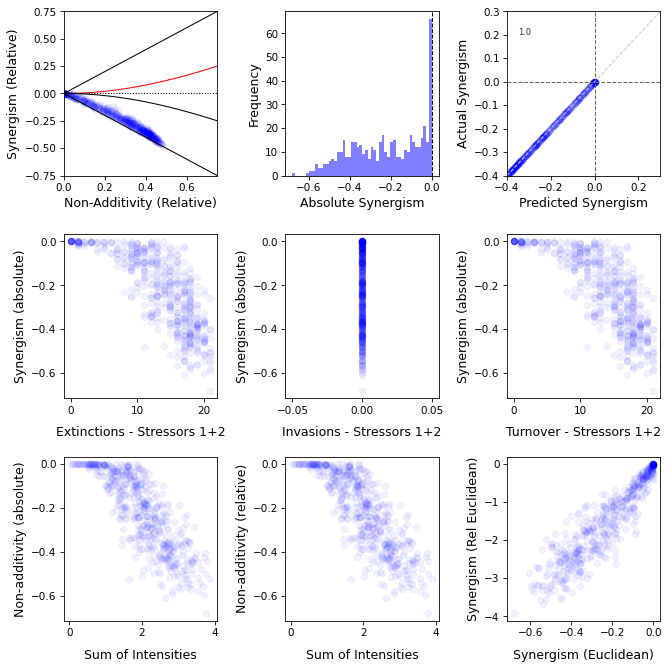

In [12]:
### Some useful plots

plt.figure(num=None, figsize=(9, 9), dpi=75, facecolor='w', edgecolor='k')

## Non-additivity vs Synergism
plt.subplot(3, 3, 1) 
plt.scatter(Non_add_rel, Synergism_rel, color='blue', alpha=0.05)
X = np.linspace(0, 2, 100)
plt.plot(X, np.sqrt(X**2+1)-1, 'red', lw=1)                    
plt.plot(X, X, 'black', lw=1) 
plt.plot([0,1,2],[0,-1,0], 'black', lw=1) 
plt.plot([0,1,2],[0,0,1], 'black', linestyle=':', lw=1)
plt.xlabel("Non-Additivity (Relative)", fontsize=12)
plt.ylabel("Synergism (Relative)", fontsize=12)
plt.xlim(0, .75)
plt.ylim(-.75, .75)
### Some theoretical predictions
## Maximum synergism for closed system with no interactions and negative stressors
plt.plot(X, -np.sqrt(2+X**2-2*np.sqrt(1+X**2)), 'k', lw=1) #label=(r'$\Omega = 0$'))

## Absolute Synergism
plt.subplot(3, 3, 2) 
plt.hist(Synergism_abs, bins = 50, color = "blue", alpha = 0.5)
plt.axvline(linewidth=1, color = "black", linestyle='--')
plt.xlabel("Absolute Synergism", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

## Synergism vs Ideal Overlap Measure (predicted from enviornmental sensitivity matrix)
plt.subplot(3, 3, 3) 
plt.scatter(predicted_Synergism_rel, Synergism_rel, color='blue', alpha=0.05)
plt.xlabel("Predicted Synergism", fontsize=12)
plt.ylabel("Actual Synergism", fontsize=12)
plt.plot([-2,2],[-2, 2], linewidth=1, color =(0.8, 0.8, 0.8), linestyle='--')
plt.xlim(-0.4, 0.3)
plt.ylim(-0.4, 0.3)
plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.axvline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.text(-0.35, 0.2, round(stats.pearsonr(predicted_Synergism_rel, Synergism_rel)[0], 2), fontsize=8, alpha = 0.8)

## Extinctions
plt.subplot(3, 3, 4) 
plt.scatter(Ext_12, Synergism_abs, alpha=0.05, color = "blue")
plt.xlabel("Extinctions - Stressors 1+2", fontsize=12, labelpad=10)
plt.ylabel("Synergism (absolute)", fontsize=12);

## Invasions
plt.subplot(3, 3, 5) 
plt.scatter(Inv_12, Synergism_abs, alpha=0.05, color = "blue")
plt.xlabel("Invasions - Stressors 1+2", fontsize=12, labelpad=10)
plt.ylabel("Synergism (absolute)", fontsize=12);

## Turnover (Extinctions + Invasions)
plt.subplot(3, 3, 6) 
plt.scatter(Ext_12+Inv_12, Synergism_abs, alpha=0.05, color = "blue")
plt.xlabel("Turnover - Stressors 1+2", fontsize=12, labelpad=10)
plt.ylabel("Synergism (absolute)", fontsize=12);

## Intensity vs Non-additivity (absolute)
plt.subplot(3, 3, 7) 
plt.scatter(intensity, Synergism_abs, alpha=0.05, color = "blue")
plt.xlabel("Sum of Intensities", fontsize=12, labelpad=10)
plt.ylabel("Non-additivity (absolute)", fontsize=12);

## Intensity vs Non-additivity (relative)
plt.subplot(3, 3, 8) 
plt.scatter(intensity, Synergism_abs, alpha=0.05, color = "blue")
plt.xlabel("Sum of Intensities", fontsize=12, labelpad=10)
plt.ylabel("Non-additivity (relative)", fontsize=12);

## Euclidean vs Rel Euclidean
plt.subplot(3, 3, 9) 
plt.scatter(Synergism_abs, Synergism_Euc2_abs, alpha=0.05, color = "blue")
plt.xlabel("Synergism (Euclidean)", fontsize=12, labelpad=10)
plt.ylabel("Synergism (Rel Euclidean)", fontsize=12);

plt.tight_layout(pad=1, w_pad=1, h_pad=1)


In [239]:
#### Stressor simulation parameters #### 
num_com = 1                               # How many interaction matricies we want
num_stress = 500                          # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 0.4                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)




S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 0.4
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  500

Persisting species:  28 / 50

0
100
200
300
400



Here are the patterns of non-additivity when there are no species interactions:

- **Negative stressors only**: Extinctions are the only source of non-additivity and are purely antagonistic. The maximum relative non-additivity is 0.5 - this represents a scenario when both stressors individually make all species go extinct. There is a curve here just above the negative boundary and the begining of this curve seems to be modified by zeta. Changing the intensity of stressors changes the area of this curve that is observed. As intensity increase the relative and absolute non-additivity increases (up to a value of 0.5 relative non-additivity or total biomass / 2 absolute non-additivity. Number of extinctions correlates with non-additivity. There can be no invasions. Predicted synergism (from enviornmnetal sensitivity matrix) is identical to actual synergism (results from dynamical models). There is a strong correlation between synergism for euclidean and relative euclidean (when axes are modified based on relative biomass). Zeta and S have no effect on results. Making stressors relative to rho of species only changes the final plot.


- **Positive stressors only**: Invasions are the only source of non-additivity and are purely synergistic. For synergism to occur both stressors must individually cause the invasion of a species, then the synergism is the area before the boundary (increase to a positive carrying capacity) that is only required to be achieved once. So as stressor intensity increase the relative, but not absolute, non-additivity will decrease (like a funnel plot). Number of invasions correlates with non-additivity. 


- **Mixed stressors**: Extinctions (antagonism), Invasions (synergism) and opposing stressors (synergism) are the sources of non-additivity. This is true as long as there are some species in the species pool but not in the assembled community. The bias/direction of the stressors controls the relative importance of extinctions/invasions and so the bias towards antagonism/synergism. The synergism from the opposing stressors is similar to the synergism from invasions, in so far as relative non-additivity will decrease as stressor intensity increases. That is why (I think) increasing intensity will make the curves identified before used to predict non-linearity of extinctions and invasions become relavant (because the non-additive effect from opposing stressors becomes negligible as intensity increases). The curves from before are all related to: 

    $y= - \sqrt{2+x^2-2\sqrt{1+x^2(x)(\Omega)}}$

    - when $\Omega = 0$ the function predicts the maximum synergism in a closed system.
    
    - when $\Omega = \sqrt{\frac{a(x) + b}{S}}$ where $a(x) + b$ is the equation of the line plotted through extinctions vs. non-additivity and $S$ is the number of species, the function predicts the actual synergism given non-additivity in a closed system. 
    
    - when flipped, the function predicts the maximum synergism in an open system (points that fall on the line are invasions with no extinctions). 



<br>
<br>
<br>
<br>
<br>

## Observation Effects <a class="anchor" id="4"></a>
[Top](#1)

By keeping track of the synergism for some commonly used response variables (Species Richness, Diversity, Total Biomass) we can compare this synergism to the synergism when Euclidean distance (absolute biomass change) is used. If these two do not correlate perfectly, then this is what we call observational effects - non-additivity can be introduced or pre-existing non-additivity can be biased or altered by how the community is observed. 

There are 9 possible outcomes:

1. additive Euclidean and additive observation
2. synergistic Euclidean and synergistic observation
3. antagonistic Euclidean and antagonistic observation
4. synergistic Euclidean and antagonistic observation 
5. antagonistic Euclidean and synergistic observation 
6. synergistic Euclidean and additive observation 
7. antagonistic Euclidean and additive observation 
8. additive Euclidean and synergistic observation 
9. additive Euclidean and antagonisitc observation

Points that fall into the 4, 5, 6, 7, 8, 9 regions are potentially problematic. It would be great it we could figure out a way of correcting these.  


In [90]:
#### Stressor simulation parameters #### 
num_com = 1                               # How many interaction matricies we want
num_stress = 500                          # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)




S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  500

Persisting species:  29 / 50

0
100
200
300
400



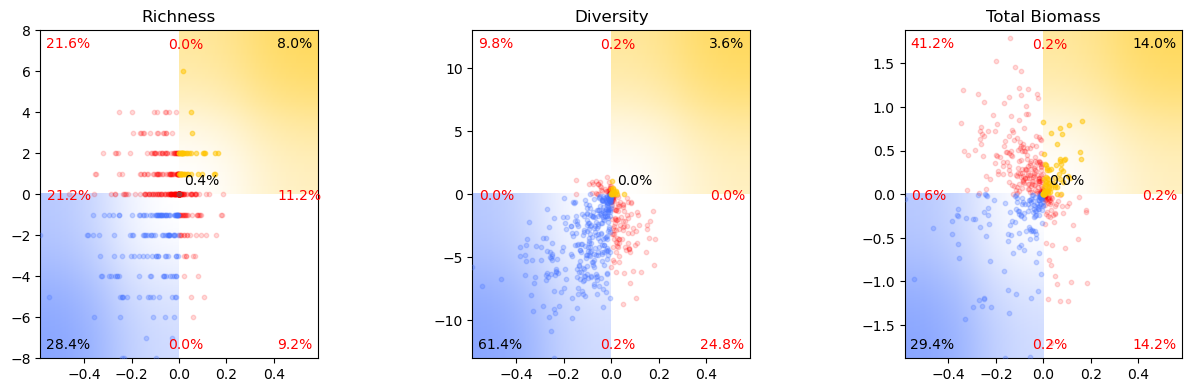

In [94]:
plt.figure(num=None, figsize=(12, 4), dpi=100, facecolor='w', edgecolor='k')

j_blue = (68/255, 114/255, 255/255)
j_yell = (255/255, 196/255, 0/255)
j_yell2 = (255/255, 150/255, 0/255)

# To create colour gradients
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
yellow_grad = ["white", j_yell]
yellow_cmap = LinearSegmentedColormap.from_list("mycmap", yellow_grad)
blue_grad = ["white", j_blue]
blue_cmap = LinearSegmentedColormap.from_list("mycmap", blue_grad)



################################# Richness #######################################

ax = plt.subplot(1, 3, 1) 
X = Synergism_abs
Y = Synergism_rich_abs
plt.title("Richness")

nb = sum(~np.isnan(Y))
Max_X = max(abs(X))
Max_Y = max(abs(Y))
plt.xlim(-Max_X, Max_X)
plt.ylim(-Max_Y, Max_Y)

plt.imshow([[1.,1.], [0.,0.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.5,
          extent = (0, Max_X, 0, Max_Y))   
plt.imshow([[0.,1.], [0.,1.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.25,
          extent = (0, Max_X, 0, Max_Y))      
plt.imshow([[0.,1.], [0.,1.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.5,
           extent = (0, -Max_X, 0, -Max_Y))   
plt.imshow([[1.,1.], [0.,0.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.25,
           extent = (0, -Max_X, 0, -Max_Y))   

A_A = np.where((X<0) & (Y<0))[0]
S_S = np.where((X>0) & (Y>0))[0]
A_S = np.where((X>0) & (Y<0))[0]
S_A = np.where((X<0) & (Y>0))[0]
ADD = np.where((X==0) & (Y==0))[0]
AD_N = np.where((X==0) & (Y!=0))[0]
N_AD = np.where((X!=0) & (Y==0))[0]
plt.scatter(X[A_A], Y[A_A], color = j_blue, alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_S], Y[S_S], color = j_yell, alpha = 0.5, zorder=150, s=10)
plt.scatter(X[ADD], Y[ADD], color = (0.4, 0.4, 0.4), alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_A], Y[S_A], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[A_S], Y[A_S], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[AD_N], Y[AD_N], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[N_AD], Y[N_AD], color = 'r', alpha = 0.15, zorder=100, s=10)

plt.text(.98, .98, str(round(len(np.where((Y > 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='right', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.02, 0.02, str(round(len(np.where((Y < 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.52, 0.52, str(round(len(np.where((Y == 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(.98, 0.02, str(round(len(np.where((Y < 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='right', va='bottom', transform=ax.transAxes, zorder=1000)           
plt.text(0.02, .98, str(round(len(np.where((Y > 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='left', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.855, 0.475, str(round(len(np.where((Y == 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.025, 0.475, str(round(len(np.where((Y == 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.935, str(round(len(np.where((Y > 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.02, str(round(len(np.where((Y < 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)




################################# Diversity #######################################

ax = plt.subplot(1, 3, 2) 
X = Synergism_abs
Y = Synergism_diversity_abs
plt.title("Diversity")

nb = sum(~np.isnan(Y))
Max_X = max(abs(X))
Max_Y = max(abs(Y))
plt.xlim(-Max_X, Max_X)
plt.ylim(-Max_Y, Max_Y)

plt.imshow([[1.,1.], [0.,0.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.5,
          extent = (0, Max_X, 0, Max_Y))   
plt.imshow([[0.,1.], [0.,1.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.25,
          extent = (0, Max_X, 0, Max_Y))      
plt.imshow([[0.,1.], [0.,1.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.5,
           extent = (0, -Max_X, 0, -Max_Y))   
plt.imshow([[1.,1.], [0.,0.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.25,
           extent = (0, -Max_X, 0, -Max_Y))   

A_A = np.where((X<0) & (Y<0))[0]
S_S = np.where((X>0) & (Y>0))[0]
A_S = np.where((X>0) & (Y<0))[0]
S_A = np.where((X<0) & (Y>0))[0]
ADD = np.where((X==0) & (Y==0))[0]
AD_N = np.where((X==0) & (Y!=0))[0]
N_AD = np.where((X!=0) & (Y==0))[0]
plt.scatter(X[A_A], Y[A_A], color = j_blue, alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_S], Y[S_S], color = j_yell, alpha = 0.5, zorder=150, s=10)
plt.scatter(X[ADD], Y[ADD], color = (0.4, 0.4, 0.4), alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_A], Y[S_A], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[A_S], Y[A_S], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[AD_N], Y[AD_N], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[N_AD], Y[N_AD], color = 'r', alpha = 0.15, zorder=100, s=10)

plt.text(.98, .98, str(round(len(np.where((Y > 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='right', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.02, 0.02, str(round(len(np.where((Y < 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.52, 0.52, str(round(len(np.where((Y == 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(.98, 0.02, str(round(len(np.where((Y < 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='right', va='bottom', transform=ax.transAxes, zorder=1000)           
plt.text(0.02, .98, str(round(len(np.where((Y > 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='left', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.855, 0.475, str(round(len(np.where((Y == 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.025, 0.475, str(round(len(np.where((Y == 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.935, str(round(len(np.where((Y > 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.02, str(round(len(np.where((Y < 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)





################################# Total Biomass #######################################

ax = plt.subplot(1, 3, 3) 
X = Synergism_abs
Y = Synergism_total_abs
plt.title("Total Biomass")

nb = sum(~np.isnan(Y))
Max_X = max(abs(X))
Max_Y = max(abs(Y))
plt.xlim(-Max_X, Max_X)
plt.ylim(-Max_Y, Max_Y)

plt.imshow([[1.,1.], [0.,0.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.5,
          extent = (0, Max_X, 0, Max_Y))   
plt.imshow([[0.,1.], [0.,1.]],
           cmap = yellow_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
          alpha = 0.25,
          extent = (0, Max_X, 0, Max_Y))      
plt.imshow([[0.,1.], [0.,1.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.5,
           extent = (0, -Max_X, 0, -Max_Y))   
plt.imshow([[1.,1.], [0.,0.]],
           cmap = blue_cmap, 
           interpolation = 'quadric',
           aspect = 'auto',
           alpha = 0.25,
           extent = (0, -Max_X, 0, -Max_Y))   

A_A = np.where((X<0) & (Y<0))[0]
S_S = np.where((X>0) & (Y>0))[0]
A_S = np.where((X>0) & (Y<0))[0]
S_A = np.where((X<0) & (Y>0))[0]
ADD = np.where((X==0) & (Y==0))[0]
AD_N = np.where((X==0) & (Y!=0))[0]
N_AD = np.where((X!=0) & (Y==0))[0]
plt.scatter(X[A_A], Y[A_A], color = j_blue, alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_S], Y[S_S], color = j_yell, alpha = 0.5, zorder=150, s=10)
plt.scatter(X[ADD], Y[ADD], color = (0.4, 0.4, 0.4), alpha = 0.25, zorder=150, s=10)
plt.scatter(X[S_A], Y[S_A], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[A_S], Y[A_S], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[AD_N], Y[AD_N], color = 'r', alpha = 0.15, zorder=100, s=10)
plt.scatter(X[N_AD], Y[N_AD], color = 'r', alpha = 0.15, zorder=100, s=10)

plt.text(.98, .98, str(round(len(np.where((Y > 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='right', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.02, 0.02, str(round(len(np.where((Y < 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.52, 0.52, str(round(len(np.where((Y == 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(.98, 0.02, str(round(len(np.where((Y < 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='right', va='bottom', transform=ax.transAxes, zorder=1000)           
plt.text(0.02, .98, str(round(len(np.where((Y > 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
         color = 'r', ha='left', va='top', transform=ax.transAxes, zorder=1000)
plt.text(0.855, 0.475, str(round(len(np.where((Y == 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.025, 0.475, str(round(len(np.where((Y == 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.935, str(round(len(np.where((Y > 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
plt.text(0.46, 0.02, str(round(len(np.where((Y < 0) & (X == 0))[0])/nb * 100, 1))+"%", fontsize=10, 
         color = 'r', ha='left', va='bottom', transform=ax.transAxes, zorder=1000)


plt.tight_layout(pad=1, w_pad=8, h_pad=1)

### Polygons to create the coloured squares
#s_s = np.array([[0,0], [Max_X, 0], [Max_X,Max_Y], [0, Max_Y]])
#a_a = np.array([[0,0], [-Max_X, 0], [-Max_X,-Max_Y], [0, -Max_Y]])
#s_a = np.array([[0,0], [0, Max_Y], [-Max_X,Max_Y], [-Max_X, 0]])
#a_s = np.array([[0,0], [0, -Max_Y], [Max_X,-Max_Y], [Max_X, 0]])
#sq1 = plt.Polygon(s_s, color=j_yell, alpha=0.6, zorder=1)
#sq2 = plt.Polygon(a_a, color=j_blue, alpha=0.4, zorder=1)
#sq3 = plt.Polygon(s_a, color='red', alpha=0.02, zorder=1)
#sq4 = plt.Polygon(a_s, color='red', alpha=0.02, zorder=1)
#plt.gca().add_patch(sq1)
#plt.gca().add_patch(sq2)
#plt.gca().add_patch(sq3)
#plt.gca().add_patch(sq4)

- Total biomass and Euclidean distance are always well correlated. Richness and Diversity are always well correlated. 


- When there are no species interactions and stressors are mixed, and there are species in the species pool that weren't in the assembled community, then there are some pretty cool patterns as the direction of stressors shifts. If you just look at the correlation between Euclidean and Richness, negative stressors result in a positive correlation, unbiasd stressors result in no correlation and positive stressors result in a negative correlation!


- The negative correlation between euclidean synergism and richness synergism for positive stressors makes sense, as to get synergism in eucledian distance both stressors can individually cause the invasion of a species and this would clearly be antagonistic for richness. But it is also possible to imagine a scenario where netiher stressor individually causes the invasion of a species, but both of them together do. Again, this would be more related to lower intensities, but as stressor intensity increases this effect might fade away.


- Zeta increases the spread of the points (spread in Euclidean synergism). But when zeta is very low  the curves from the overlap section (below) seem to be relevant! As euclidean synergism increases richness synergism increases at first and then decreases - it definitely feels like there is a connection here. This curves goes away as zeta increases, just as it does for the stressor overlap curves. 


- Increasing stressor intensity will shift the center of the cloud of points downwards - different part of the relationship is getting sampled. Similar to overlap curves! 


- There is sometimes a weird discontinuity for the diversity synergism (e.g. S=20, Intensity=20). Is this related to some weird discontinuity in the function itself?  


- Species interactions don't really influence the results, which is very nice!


- Things get a funky when you consider type II stressors. 


- There is clearly non-additivity introduced through observation effects

<br>
<br>
<br>
<br>
<br>

## Stressor overlap <a class="anchor" id="5"></a>
[Top](#1)

This is an exploration of the concept of cotolerance (overlap of stressors). We are trying to make that concept more quantitative. Is there some measure of overlap that can predict synergism? We have some intuitions for Euclidean distance and for species richness (and so this actually also falls in nicely with diversity and total biomass).

The dot product of the bounded effect of stressors does a pretty good job when stressor effects are negative. Even when there are species interactions it seems to be pretty good. 

But what about when stressors can have a positive effect it is no longer a very good measure. We tried using a prefactor to remove stressors that were both purely positive - but the chances of getting a purely positive stressor decreases rapidly as S increases (even S of 10 is too high). 

To account for species interactions we can consider another measure of stressor overlap, which uses the environmental sensitivity matrix to access the net effect of stressors. This doesn't seem necessary at the moment. 


In [70]:
#### Stressor simulation parameters #### 
num_com = 1                               # How many interaction matricies we want
num_stress = 500                          # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)




S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  500

Persisting species:  22 / 50

0
100
200
300
400



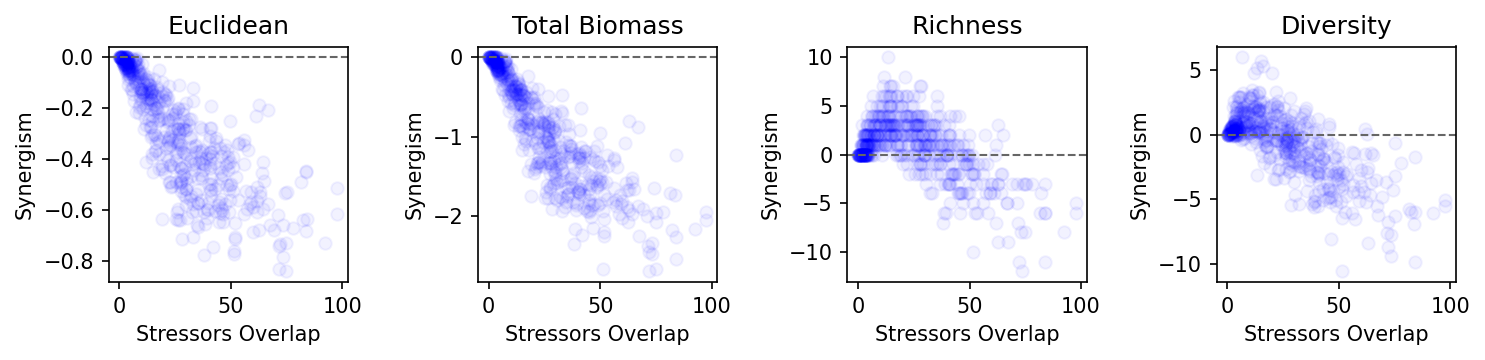

In [71]:
plt.figure(num=None, figsize=(10, 2.5), dpi=150, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1) 
plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.scatter(Dot_bound, Synergism_abs, alpha=0.05, color = "blue")
plt.title("Euclidean", fontsize=12)
plt.xlabel("Stressors Overlap", fontsize=10)
plt.ylabel("Synergism", fontsize=10)

plt.subplot(1, 4, 2) 
plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.scatter(Dot_bound, Synergism_total_abs, alpha=0.05, color = "blue")
plt.title("Total Biomass", fontsize=12)
plt.xlabel("Stressors Overlap", fontsize=10)
plt.ylabel("Synergism", fontsize=10)

plt.subplot(1, 4, 3) 
plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.scatter(Dot_bound, Synergism_rich_abs, alpha=0.05, color = "blue")
plt.title("Richness", fontsize=12)
plt.xlabel("Stressors Overlap", fontsize=10)
plt.ylabel("Synergism", fontsize=10)

plt.subplot(1, 4, 4) 
plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
plt.scatter(Dot_bound, Synergism_diversity_abs, alpha=0.05, color = "blue")
plt.title("Diversity", fontsize=12)
plt.xlabel("Stressors Overlap", fontsize=10)
plt.ylabel("Synergism", fontsize=10)

plt.tight_layout()


Right now these are only really relevant for purely negative stressors

- Increasing the number of species does not change the pattern


- Increasing species interactions adds more noise - but the pattern tends to hold


- We still see this strange discontinuity with diversity (at higher stressor intensities). 


- These curves seem very relevant to the observation effects


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Predicted vs Actual Synergism <a class="anchor" id="6"></a>
[Top](#1)

Here we are interested in comparing the synergism predicted using the net effects of stressors (accessible using the environmental sensititivity matrix), to the actual synergism resulting from the dynamical models. 

Jeff calls the first of these, the "ideal overlap measure" of stressors - it connects closely to the concept of stressor overlap and to the synergism caused by opposing stressors in closed, non-interacting communities. The idea was that interactions transformed the net effect of stressors so that even if the direct effects of two stressors were negative, with interactions the net effects could be opposing - the idea was that this explained the synergism that we were seeing for species interactions. Although we're not really sure if that's the case. It doesn't seem like species interactions change the sign of stressors.  

S:  20
zeta:  0.2
mu:  0.0
sigma:  0.0
Invasions: No

Type I effects: Negative
Type_I Direction: 0 +- 1
Type_I Intensity: 0 to 10
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  50

Persisting species:  20 / 20

0

S:  20
zeta:  0.2
mu:  0.0
sigma:  0.1
Invasions: No

Type I effects: Negative
Type_I Direction: 0 +- 1
Type_I Intensity: 0 to 10
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  50

Persisting species:  20 / 20

0

S:  20
zeta:  0.2
mu:  0.0
sigma:  0.2
Invasions: No

Type I effects: Negative
Type_I Direction: 0 +- 1
Type_I Intensity: 0 to 10
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  50

Persisting species:  20 / 20

0

S:  20
zeta:  0.2
mu:  0.0
sigma:  0.30000000000000004
Invasions: No

Type I effects: Negative
Type_I Direction: 0 +- 1
Type_I Intensity: 0 to 10
Type II effects: No

Number of comm

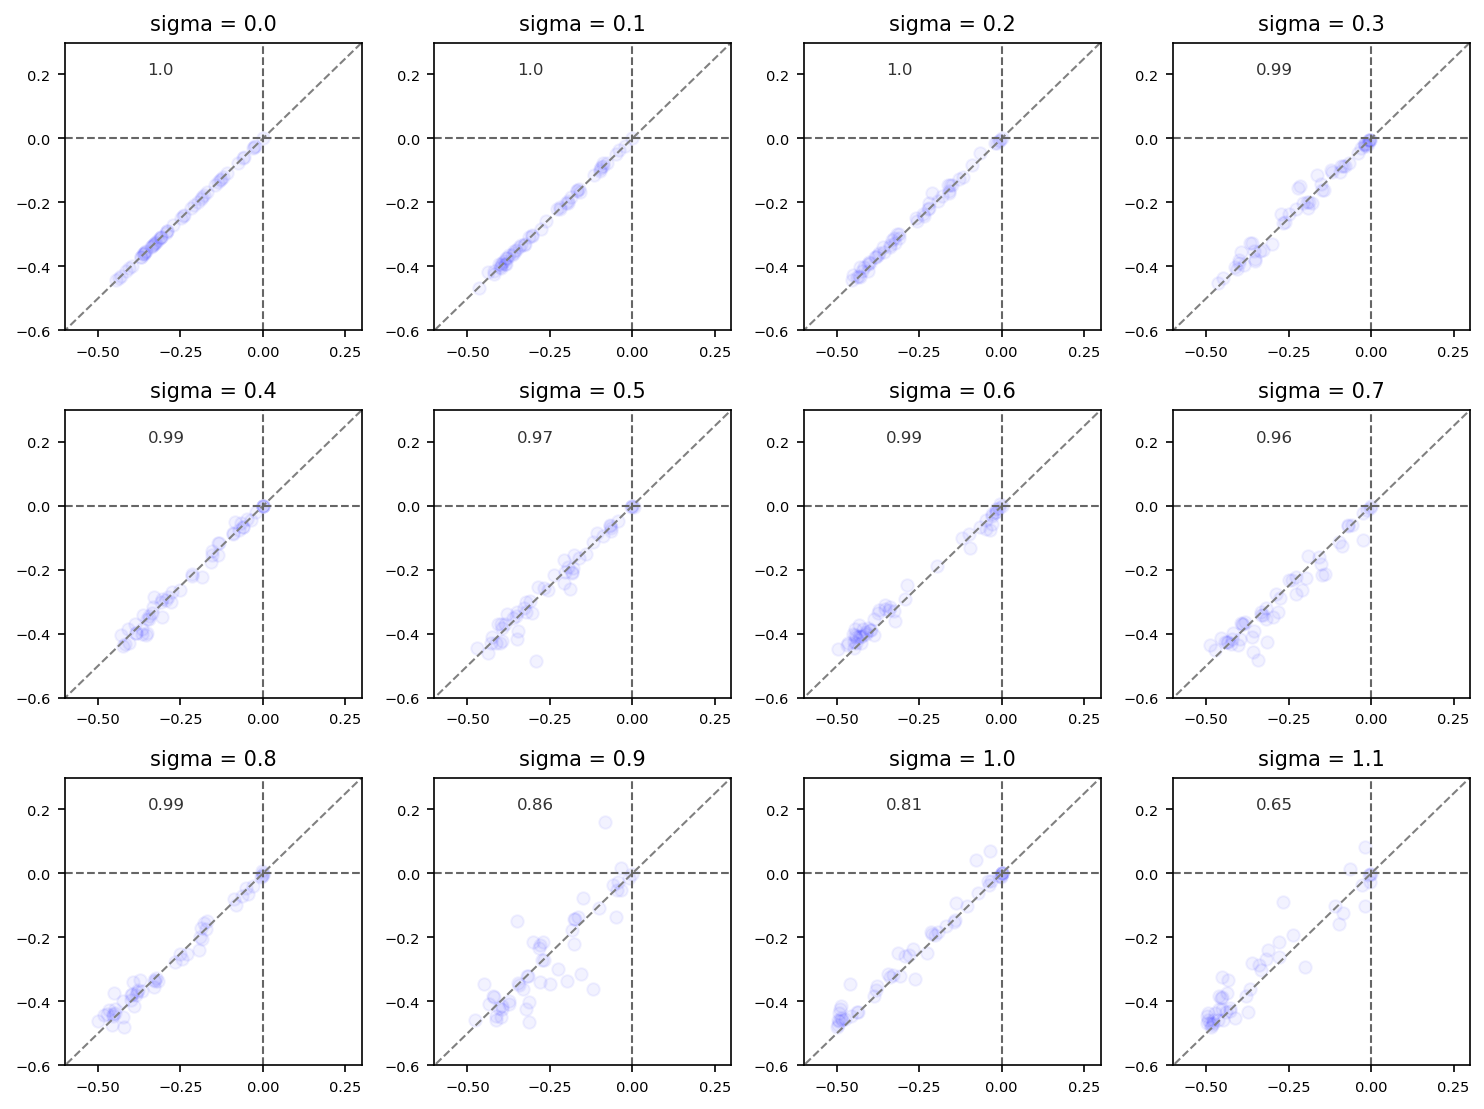

In [147]:
plt.figure(num=None, figsize=(10, 7.5), dpi=150, facecolor='w', edgecolor='k')


#### Stressor simulation parameters #### 
num_com = 1                              # How many interaction matricies we want
num_stress = 50                             # Number of stressor simulations

#### Community parameters ####
S = 20                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  

#### System type #### 
system = "closed"                         # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                            # "neg" means that type I stressors are always negative 
sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 10                                 # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                          # "true" means that type II effects will be added in 
sII_i = 1                                 # intensity of sII effects


# Number of subplots and models to run
nb = 12

for n in range(nb):
    sigma = 0.1 * n
    intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)

    
    plt.subplot(3, 4, 1+n)
    plt.scatter(predicted_Synergism_rel, Synergism_rel, color='blue', alpha=0.05)
    plt.text(-0.35, 0.2, round(stats.pearsonr(predicted_Synergism_rel, Synergism_rel)[0], 2), fontsize=8, alpha = 0.8)
    plt.title("sigma = "+str(round(sigma, 1)), fontsize=10)
    plt.plot([-2,2],[-2, 2], linewidth=1, color =(0.5, 0.5, 0.5), linestyle='--')
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xlim(-0.6, 0.3)
    plt.ylim(-0.6, 0.3)
    plt.axhline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')
    plt.axvline(linewidth=1, color =(0.4, 0.4, 0.4), linestyle='--')


    #plt.hist(Synergism_rel, bins = 50, color = "blue", alpha = 0.5)
    #plt.axvline(linewidth=1, color = "black", linestyle='--')
    #plt.title("sigma = "+str(round(sigma, 1)), fontsize=10)

    plt.tight_layout()


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Species Interactions

### Non-additivity and stability 

### Worst case stressors 

### Transformation of preexisting non-additivity

In [ ]:
#### TAKEN FROM THE OLD NOTEBOOK 
#### The below code is used to calculate the worst case type I and associated type II stressors for each community 
#### This should correlate to stability!
#### need to integrate this into my own code

#B_inv = inv(np.eye(S)+alpha)
#B_B = np.dot(B_inv.T, B_inv)
#worst_I = eig(B_B)[1][:, 0]
#w_I = np.reshape(worst_I, (S, 1))
#worst_response = (np.dot(B_inv, worst_I)) / norm(np.dot(B_inv, worst_I))
#w_R = np.reshape(worst_response, (S, 1)) 
#worst_II = np.dot(w_R, w_I.T)
    
#effect_w_I = -np.dot(B_inv, eps1*worst_I)
    
#N_eps = np.dot(inv(np.eye(S)+alpha+eps2*worst_II), np.ones(S))
#effect_w_II = Neq-N_eps
    
#N_eps_combined = np.dot(inv(np.eye(S)+alpha+eps2*worst_II), np.ones(S)+eps1*worst_I)
#effect_w_combined = Neq-N_eps_combined
    
#Worst_Non_add[k] = norm(effect_w_combined - (effect_w_I+effect_w_II))
    

In [49]:
#### Stressor simulation parameters #### 
num_com = 500                             # How many interaction matricies we want
num_stress = 1                            # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.5                               # Distribution of interaction strengths

#### System type #### 
system = "open"                           # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 1                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "true"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)



S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.5
Invasions: Yes

Type I effects: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 1
Type II effects: Yes
Type_II Intensity: np.random.uniform( 0, 1 )

Number of communities to generate:  500
Number of stressor experiments per community:  1

0


/Users/jamesorr/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


50
100
150
200
250
300
350
400
450



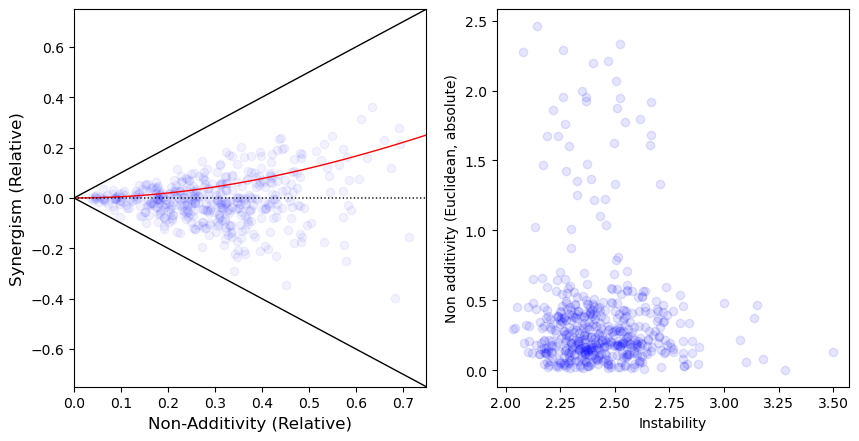

In [52]:
plt.figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')


plt.subplot(1, 2, 1) 
plt.scatter(Non_add_rel, Synergism_rel, color='blue', alpha=0.05)
X = np.linspace(0, 2, 100)
plt.plot(X, np.sqrt(X**2+1)-1, 'red', lw=1)                    
plt.plot(X, X, 'black', lw=1) 
plt.plot([0,1,2],[0,-1,0], 'black', lw=1) 
plt.plot([0,1,2],[0,0,1], 'black', linestyle=':', lw=1)
plt.xlabel("Non-Additivity (Relative)", fontsize=12)
plt.ylabel("Synergism (Relative)", fontsize=12)
plt.xlim(0, .75)
plt.ylim(-.75, .75)



plt.subplot(1, 2, 2) 
plt.scatter(1/Stab, Non_add_abs, alpha=0.1, color = "blue")
plt.xlabel("Instability", fontsize=10)
plt.ylabel("Non additivity (Euclidean, absolute)", fontsize=10);


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Sources of Non-additivity - Figure <a class="anchor" id="7"></a>
[Top](#1)

In [199]:
#### Stressor simulation parameters #### 
num_com = 1                                 # How many interaction matricies we want
num_stress = 1000                           # Number of stressor simulations

#### Community parameters ####
S = 50                                      # Number of species    
zeta = 0.2                                  # Scaling carrying capacity (rho)
cen = 0.0                                   # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                    # Mean interaction strength  
sigma = 0.0                                 # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#######################################################################################################

#### 1 - Negative, no interactions ####
Type_I = "neg" 
sigma = 0.0
_, _, _, _, _, _, _, _, _, Non_add_abs1, Non_add_rel1, Synergism_rel1, Synergism_abs1, Synergism_rich_abs1, Synergism_diversity_abs1, Synergism_total_abs1, Synergism_hill_abs1, Synergism_simp_abs1, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)


#### 2 - Negative, strong interactions ####
Type_I = "neg" 
sigma = 1.0
_, _, _, _, _, _, _, _, _, Non_add_abs2, Non_add_rel2, Synergism_rel2, Synergism_abs2, Synergism_rich_abs2, Synergism_diversity_abs2, Synergism_total_abs2, Synergism_hill_abs2, Synergism_simp_abs2, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)

 
#### 3 - Positive, no interactions ####
sI_i = 3             # to explore full area
Type_I = "pos" 
sigma = 0.0
_, _, _, _, _, _, _, _, _, Non_add_abs3, Non_add_rel3, Synergism_rel3, Synergism_abs3, Synergism_rich_abs3, Synergism_diversity_abs3, Synergism_total_abs3, Synergism_hill_abs3, Synergism_simp_abs3, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)


#### 4 - Positive, strong interactions ####
Type_I = "pos" 
sigma = 1.0
_, _, _, _, _, _, _, _, _, Non_add_abs4, Non_add_rel4, Synergism_rel4, Synergism_abs4, Synergism_rich_abs4, Synergism_diversity_abs4, Synergism_total_abs4, Synergism_hill_abs4, Synergism_simp_abs4, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)


#### 5 - Mixed, no interactions ####
sI_i = 1            # to avoid bias towards extinctions
Type_I = "all" 
sigma = 0.0
_, _, _, _, _, _, _, _, _, Non_add_abs5, Non_add_rel5, Synergism_rel5, Synergism_abs5, Synergism_rich_abs5, Synergism_diversity_abs5, Synergism_total_abs5, Synergism_hill_abs5, Synergism_simp_abs5, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)

#### 6 - Mixed, strong interactions ####
Type_I = "all" 
sigma = 1.0
_, _, _, _, _, _, _, _, _, Non_add_abs6, Non_add_rel6, Synergism_rel6, Synergism_abs6, Synergism_rich_abs6, Synergism_diversity_abs6, Synergism_total_abs6, Synergism_hill_abs6, Synergism_simp_abs6, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)





S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  23 / 50

0
100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  1.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  22 / 50

0


/Users/jamesorr/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Positive
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 3
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  30 / 50

0
100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  1.0
Invasions: Yes

Type I effects: Positive
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 3
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  26 / 50

0
100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 1
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  21 / 50

0
100
200
300
400
500
600
700
800
90

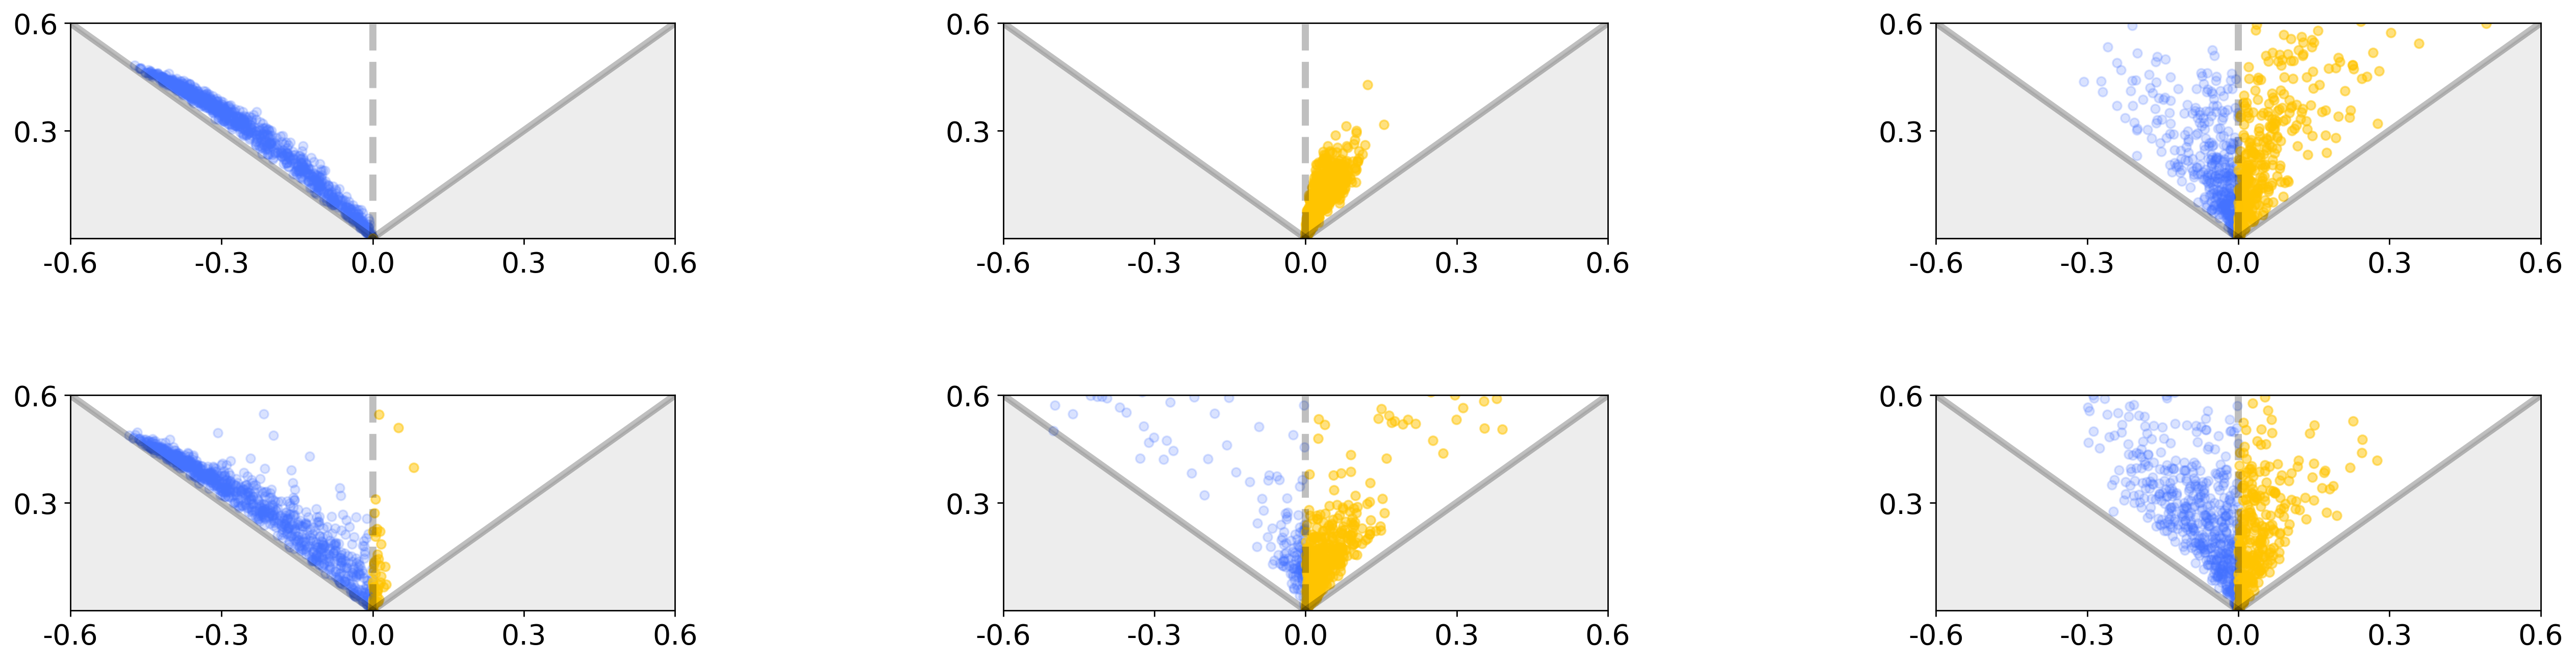

In [201]:
plt.figure(num=None, figsize=(20, 5), dpi=250, facecolor='w', edgecolor='k')

boundary_effect_plot(Synergism_rel1, Non_add_rel1, 2, 3, 1)

boundary_effect_plot(Synergism_rel2, Non_add_rel2, 2, 3, 4)

boundary_effect_plot(Synergism_rel3, Non_add_rel3, 2, 3, 2)

boundary_effect_plot(Synergism_rel4, Non_add_rel4, 2, 3, 5)

boundary_effect_plot(Synergism_rel5, Non_add_rel5, 2, 3, 3)

boundary_effect_plot(Synergism_rel6, Non_add_rel6, 2, 3, 6)

plt.tight_layout(pad=0, w_pad=14, h_pad=6)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Observation Effects - Figure <a class="anchor" id="8"></a>
[Top](#1)

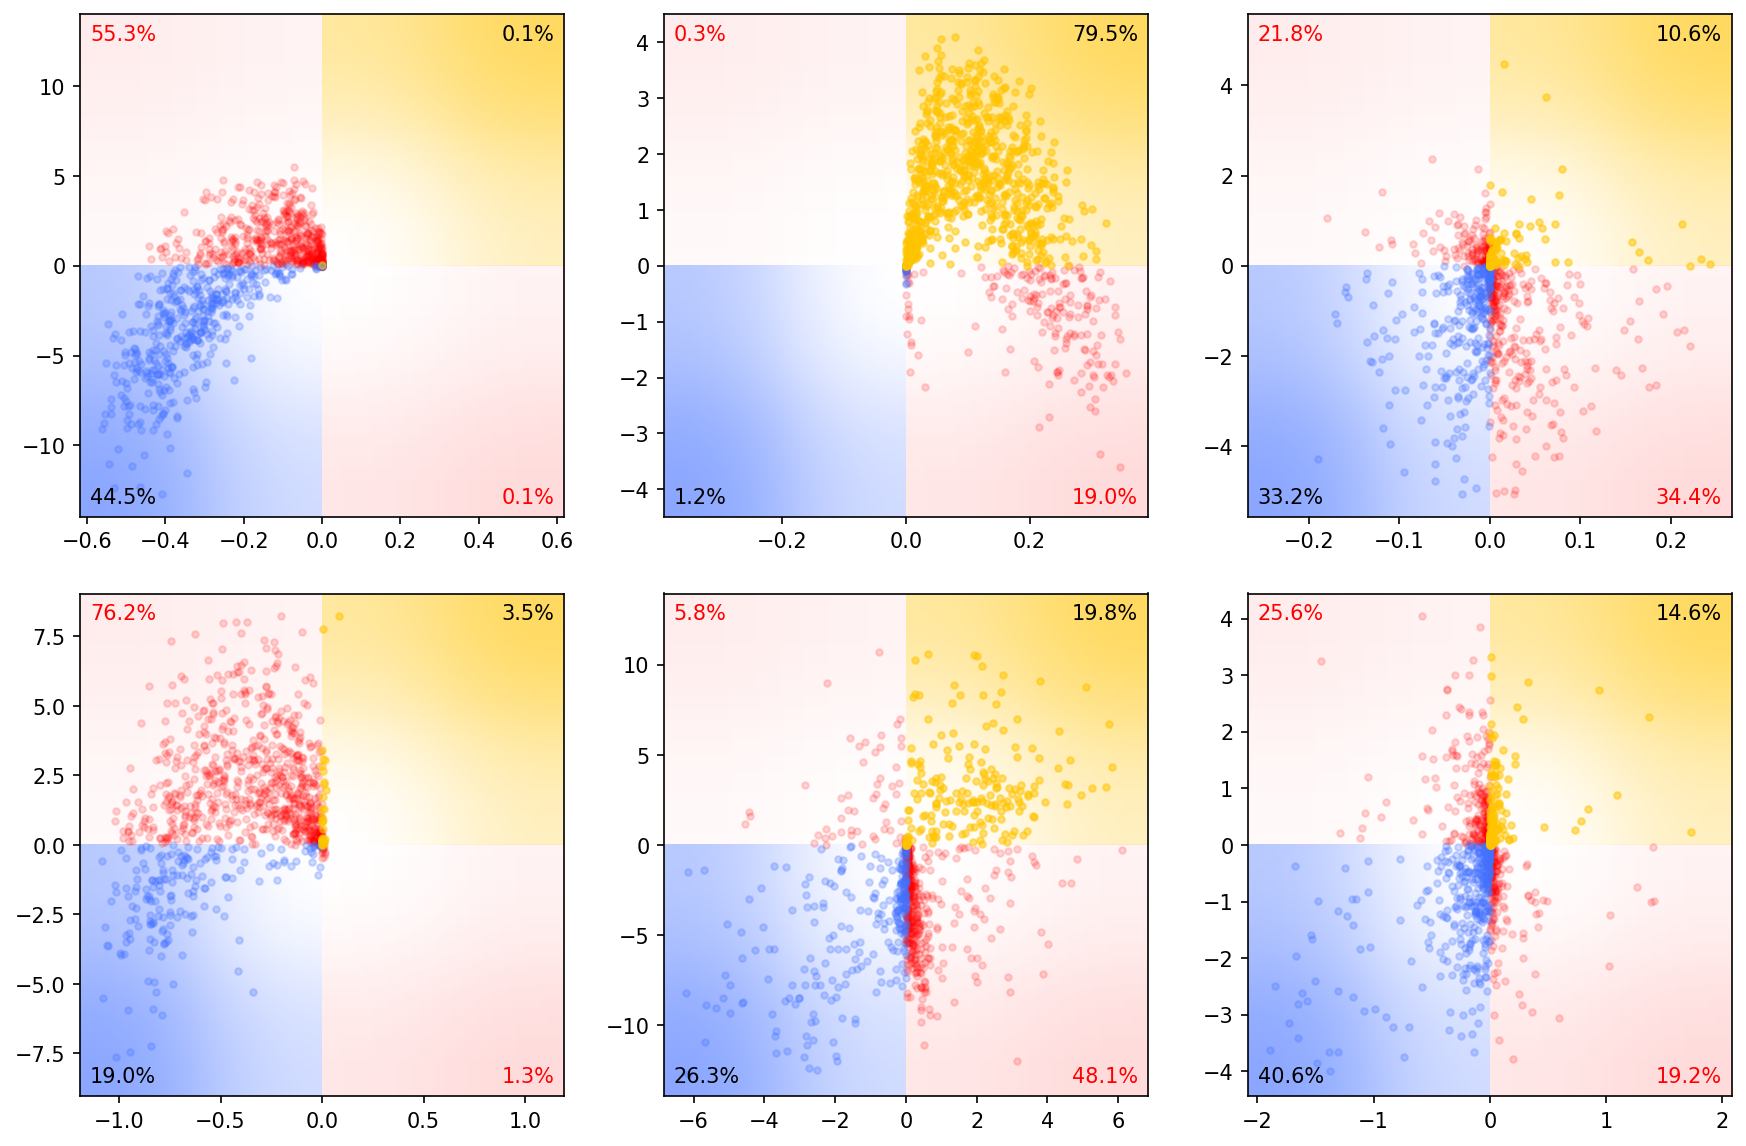

In [205]:
plt.figure(num=None, figsize=(12, 8), dpi=150, facecolor='w', edgecolor='k')

percentile = 99

################################# neg, no int #######################################

X = Synergism_abs1
Y = Synergism_diversity_abs1
observation_effect_plot(X, Y, percentile, 2, 3, 1)


################################# neg, strong int #######################################

X = Synergism_abs2
Y = Synergism_diversity_abs2
observation_effect_plot(X, Y, percentile, 2, 3, 4)


################################# pos, no int #######################################

X = Synergism_abs3
Y = Synergism_diversity_abs3
observation_effect_plot(X, Y, percentile, 2, 3, 2)


################################# pos, strong int #######################################

X = Synergism_abs4
Y = Synergism_diversity_abs4
observation_effect_plot(X, Y, percentile, 2, 3, 5)


################################# all, no int #######################################

X = Synergism_abs5
Y = Synergism_diversity_abs5
observation_effect_plot(X, Y, percentile, 2, 3, 3)


################################# all, strong int #######################################

X = Synergism_abs6
Y = Synergism_diversity_abs6
observation_effect_plot(X, Y, percentile, 2, 3, 6)


plt.tight_layout(pad=2, h_pad=2);

In [52]:
#### Stressor simulation parameters #### 
num_com = 1                                # How many interaction matricies we want
num_stress = 500                          # Number of stressor simulations

#### Community parameters ####
S = 50                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                 # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 1                                   # intensity of sII effects

#### Run the stressor simulations ####
Synergism_Euc2_abs, intensity, predicted_Non_add_rel, predicted_Synergism_rel, predicted_Non_add_abs, predicted_Synergism_abs, Stab, Stab_Relative, Resilience, Non_add_abs, Non_add_rel, Synergism_rel, Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, Synergism_hill_abs, Synergism_simp_abs, Synergism_rich_rel, Synergism_diversity_rel, Synergism_total_rel, Ext_1, Ext_2, Ext_12, Inv_1, Inv_2, Inv_12, Dot_bound = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)




S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 2
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  500

Persisting species:  22 / 50

0
100
200
300
400



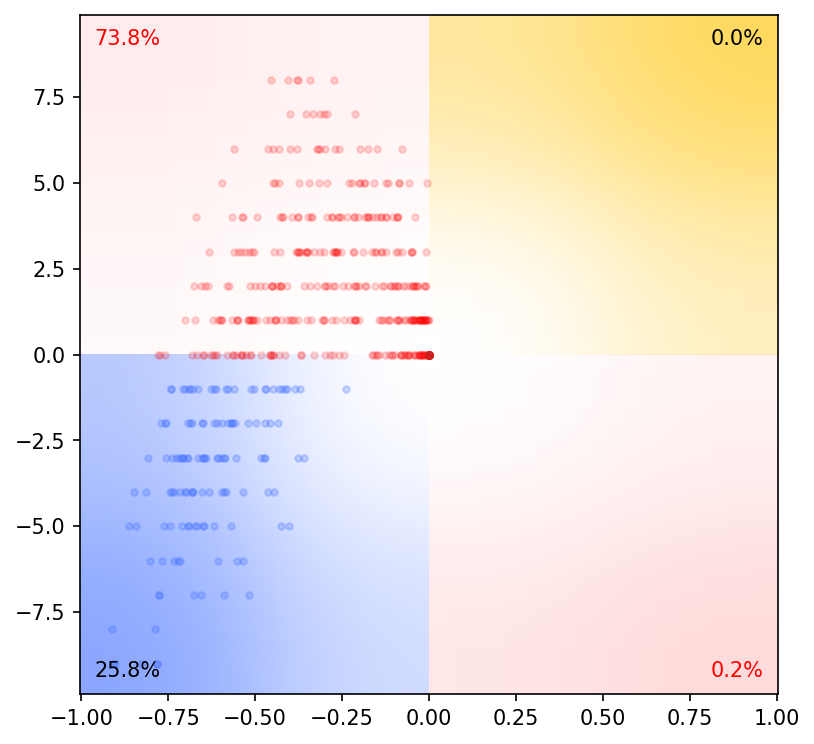

In [53]:
plt.figure(num=None, figsize=(6, 6), dpi=150, facecolor='w', edgecolor='k')
X = Synergism_abs
Y = Synergism_rich_abs
percentile = 100
observation_effect_plot(X, Y, percentile, 1, 1, 1)

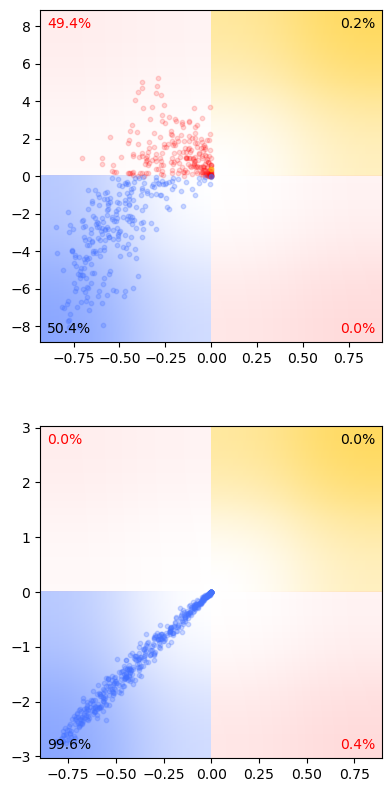

In [54]:
plt.figure(num=None, figsize=(4, 8), dpi=100, facecolor='w', edgecolor='k')

################################# Diversity #######################################

X = Synergism_abs
Y = Synergism_diversity_abs
percentile = 99
observation_effect_plot(X, Y, percentile, 2, 1, 1)


################################# Total Biomass #######################################

X = Synergism_abs
Y = Synergism_total_abs
percentile = 99
observation_effect_plot(X, Y, percentile, 2, 1, 2)

plt.tight_layout(pad=1, h_pad=4)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## More response variables 

In [66]:
#### Stressor simulation parameters #### 
num_com = 1                                 # How many interaction matricies we want
num_stress = 1000                           # Number of stressor simulations

#### Community parameters ####
S = 50                                      # Number of species    
zeta = 0.2                                  # Scaling carrying capacity (rho)
cen = 0.0                                   # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                    # Mean interaction strength  
sigma = 0.0                                 # Distribution of interaction strengths

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.                                   # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 10                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Stressor type II effects ####
Type_II = "nope"                            # "true" means that type II effects will be added in 
sII_i = 5                                   # intensity of sII effects

#######################################################################################################

#### 1 - Negative, no interactions ####
Type_I = "neg" 
_, _, _, _, _, _, _, _, _, Non_add_abs1, Non_add_rel1, Synergism_rel1, Synergism_abs1, Synergism_rich_abs1, Synergism_diversity_abs1, Synergism_total_abs1, Synergism_hill_abs1, Synergism_simp_abs1, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)

 
#### 2 - Positive, no interactions ####
sI_i = 3             # to explore full area
Type_I = "pos" 
sigma = 0.0
_, _, _, _, _, _, _, _, _, Non_add_abs3, Non_add_rel3, Synergism_rel3, Synergism_abs3, Synergism_rich_abs3, Synergism_diversity_abs3, Synergism_total_abs3, Synergism_hill_abs3, Synergism_simp_abs3, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)


#### 5 - Mixed, no interactions ####
sI_i = 1            # to avoid bias towards extinctions
Type_I = "all" 
sigma = 0.0
_, _, _, _, _, _, _, _, _, Non_add_abs5, Non_add_rel5, Synergism_rel5, Synergism_abs5, Synergism_rich_abs5, Synergism_diversity_abs5, Synergism_total_abs5, Synergism_hill_abs5, Synergism_simp_abs5, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_com, num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, Type_II, sII_i)





S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Negative
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 10
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  27 / 50

0
100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Positive
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 3
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  23 / 50

0
100
200
300
400
500
600
700
800
900

S:  50
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
Invasions: Yes

Type I effects: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 1
Type II effects: No

Number of communities to generate:  1
Number of stressor experiments per community:  1000

Persisting species:  22 / 50

0
100
200
300
400
500
600
700
800
900



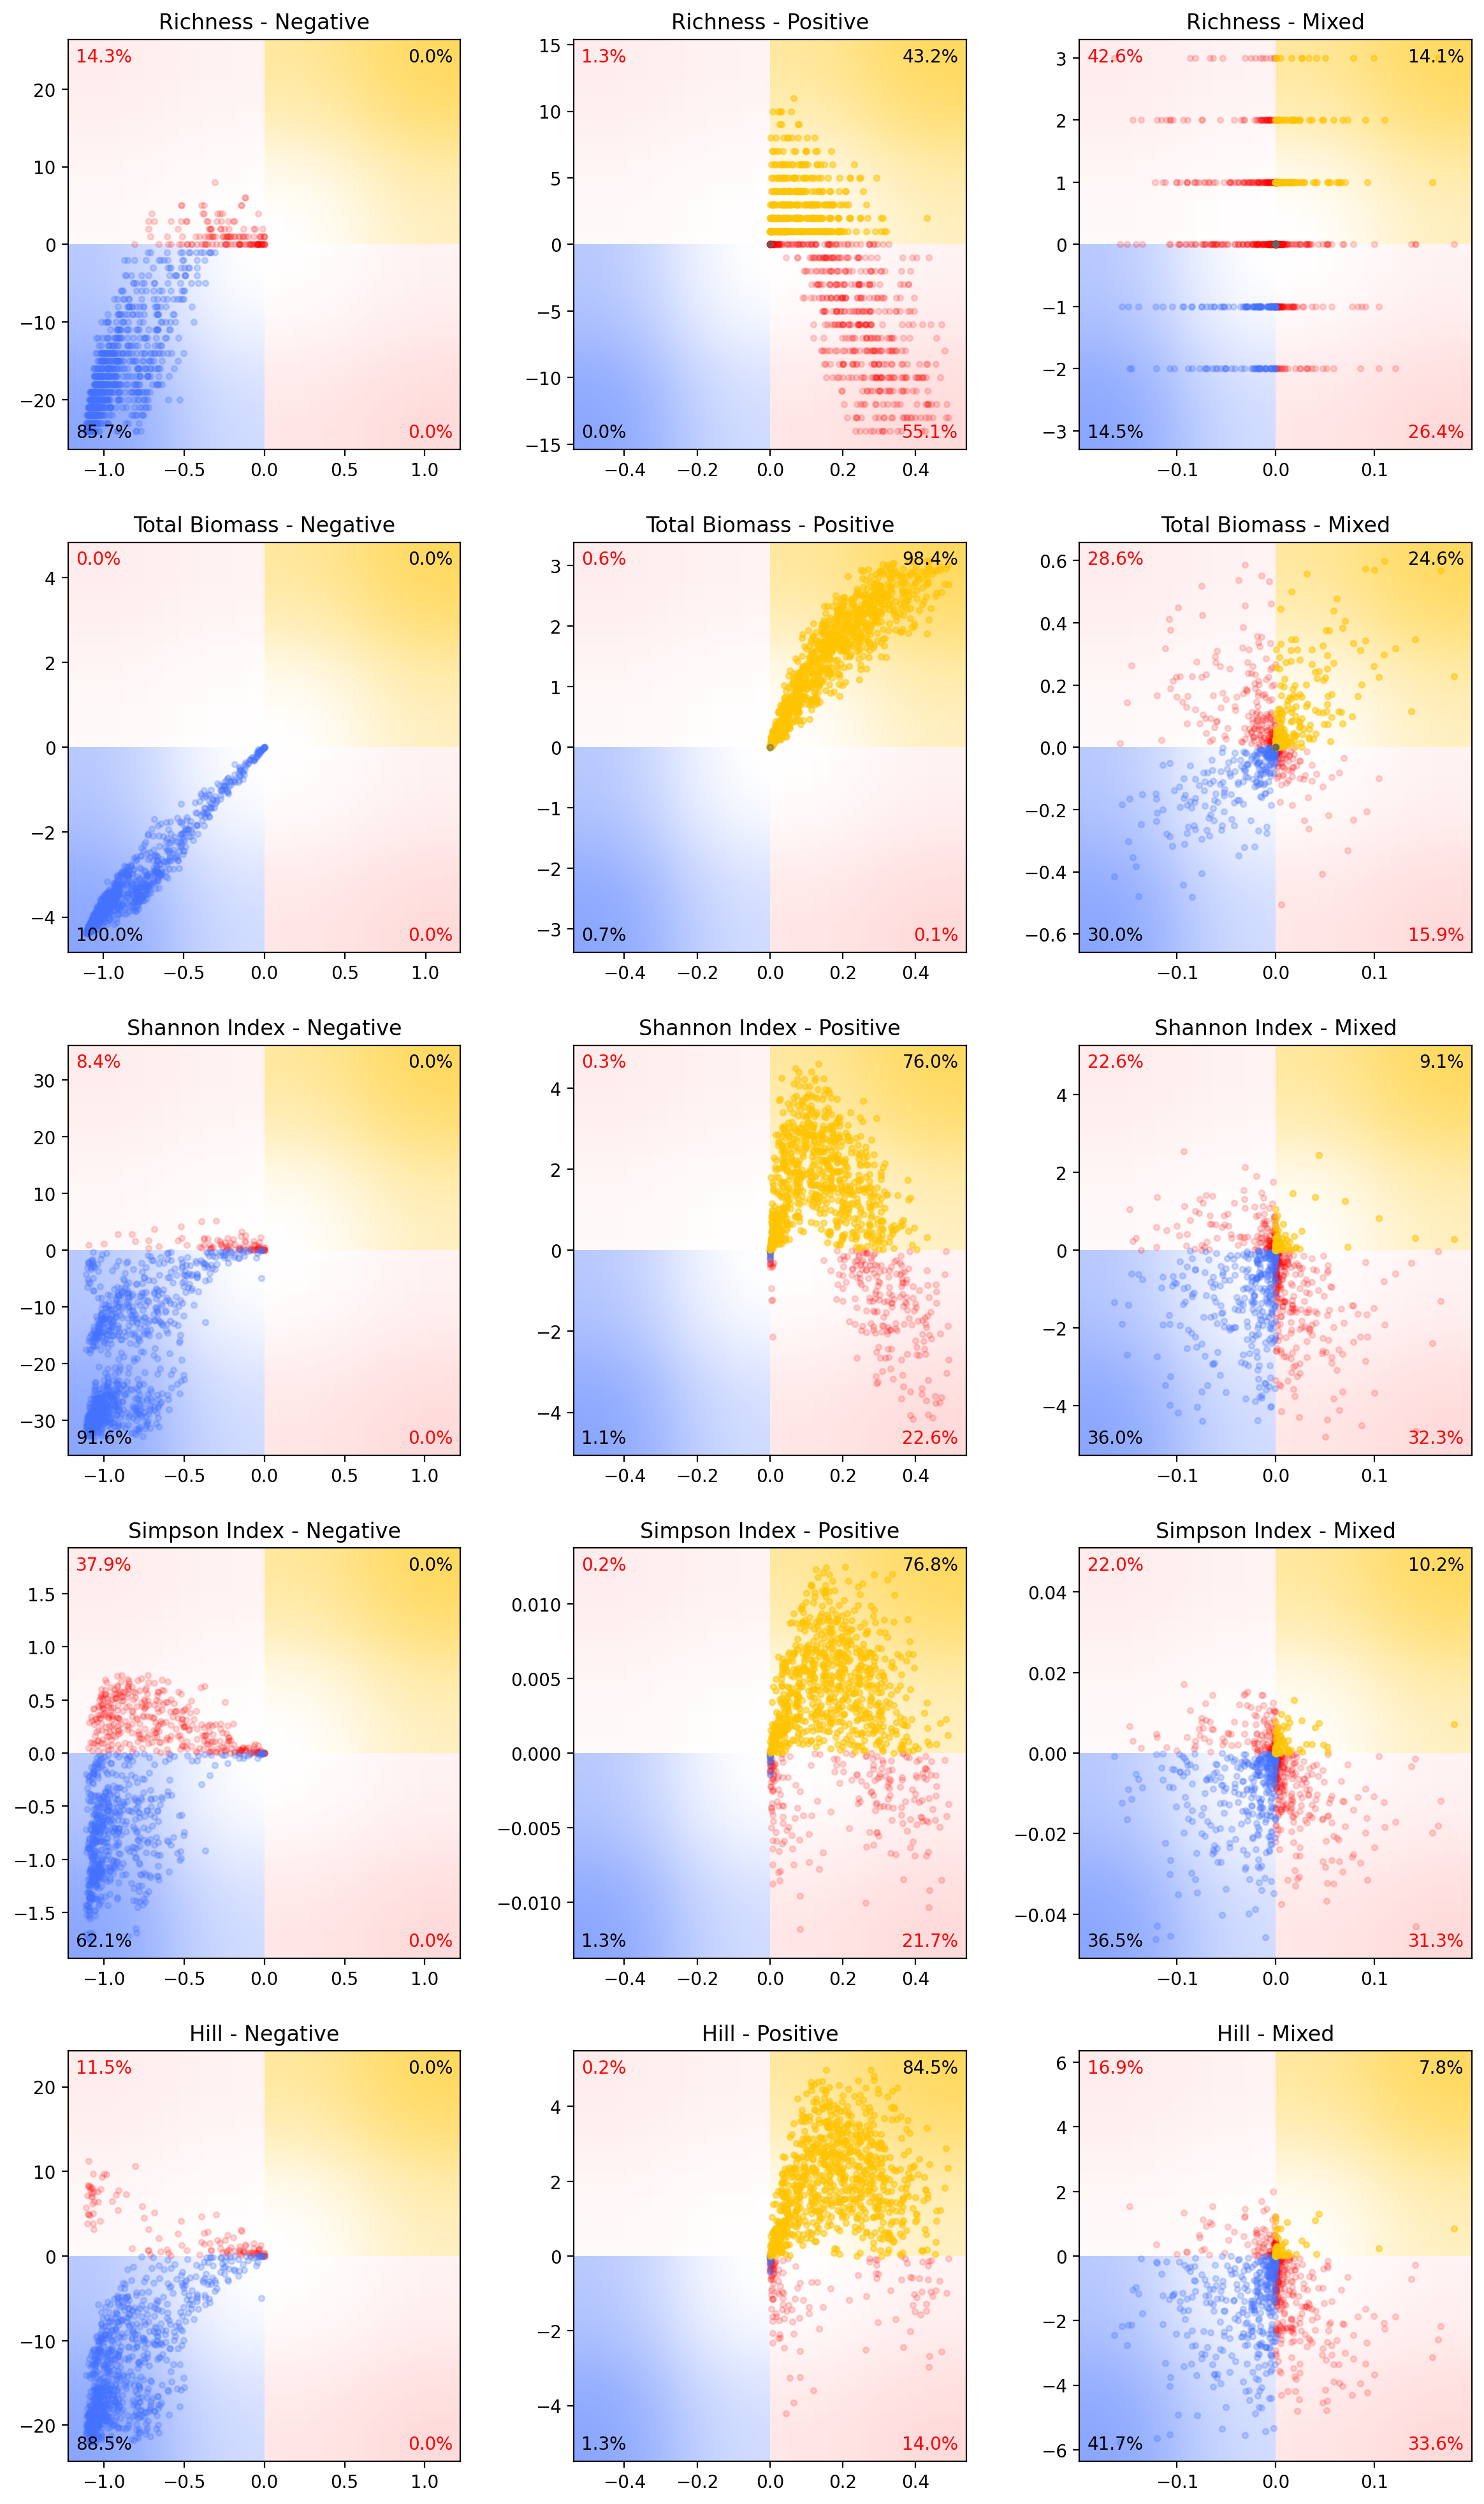

In [67]:
plt.figure(num=None, figsize=(12, 20), dpi=200, facecolor='w', edgecolor='k')


percentile = 99

################################# Richness #######################################

X = Synergism_abs1
Y = Synergism_rich_abs1
observation_effect_plot(X, Y, percentile, 5, 3, 1)
plt.title("Richness - Negative")

X = Synergism_abs3
Y = Synergism_rich_abs3
observation_effect_plot(X, Y, percentile, 5, 3, 2)
plt.title("Richness - Positive")

X = Synergism_abs5
Y = Synergism_rich_abs5
observation_effect_plot(X, Y, percentile, 5, 3, 3)
plt.title("Richness - Mixed")



################################# Total Biomass #######################################

X = Synergism_abs1
Y = Synergism_total_abs1
observation_effect_plot(X, Y, percentile, 5, 3, 4)
plt.title("Total Biomass - Negative")

X = Synergism_abs3
Y = Synergism_total_abs3
observation_effect_plot(X, Y, percentile, 5, 3, 5)
plt.title("Total Biomass - Positive")

X = Synergism_abs5
Y = Synergism_total_abs5
observation_effect_plot(X, Y, percentile, 5, 3, 6)
plt.title("Total Biomass - Mixed")



################################# Shannon #######################################

X = Synergism_abs1
Y = Synergism_diversity_abs1
observation_effect_plot(X, Y, percentile, 5, 3, 7)
plt.title("Shannon Index - Negative")

X = Synergism_abs3
Y = Synergism_diversity_abs3
observation_effect_plot(X, Y, percentile, 5, 3, 8)
plt.title("Shannon Index - Positive")

X = Synergism_abs5
Y = Synergism_diversity_abs5
observation_effect_plot(X, Y, percentile, 5, 3, 9)
plt.title("Shannon Index - Mixed")



################################# Simpson #######################################

X = Synergism_abs1
Y = Synergism_simp_abs1
observation_effect_plot(X, Y, percentile, 5, 3, 10)
plt.title("Simpson Index - Negative")

X = Synergism_abs3
Y = Synergism_simp_abs3
observation_effect_plot(X, Y, percentile, 5, 3, 11)
plt.title("Simpson Index - Positive")

X = Synergism_abs5
Y = Synergism_simp_abs5
observation_effect_plot(X, Y, percentile, 5, 3, 12)
plt.title("Simpson Index - Mixed")



################################# Hill #######################################

X = Synergism_abs1
Y = Synergism_hill_abs1
observation_effect_plot(X, Y, percentile, 5, 3, 13)
plt.title("Hill - Negative")

X = Synergism_abs3
Y = Synergism_hill_abs3
observation_effect_plot(X, Y, percentile, 5, 3, 14)
plt.title("Hill - Positive")

X = Synergism_abs5
Y = Synergism_hill_abs5
observation_effect_plot(X, Y, percentile, 5, 3, 15)
plt.title("Hill - Mixed")


plt.tight_layout(pad=2, h_pad=2)

